In [3]:
# p1_alma_greyscale_contours.py

import pandas as pd
import numpy as np
import pickle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Ellipse, Circle, Arrow
from astropy.modeling.functional_models import Ellipse2D
from astropy.cosmology import FlatLambdaCDM
from matplotlib.ticker import FormatStrFormatter
import os
from uncertainties import ufloat
from uncertainties.umath import *
from astropy.io import ascii
from astropy.table import Table
import glob
from statmorph.utils.image_diagnostics import make_figure
import statmorph
import photutils
import scipy.ndimage as ndi
from radio_beam import Beam
from astropy.nddata import Cutout2D

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
path = "/Volumes/T7/BCG_Dust_Continuum/"
os.chdir(path)

bcg_info = pd.read_csv("data/bcg_info/bcg_basic_data.csv", header=0)

file_ids = bcg_info['file_id']
rms = bcg_info['RMS']
sn = bcg_info['S/N']
step = bcg_info['contour_steps']
z = bcg_info['redshift']
spec_z = bcg_info['spec_z']

image_path = "data/tclean_output/natural_imaging/"
bcgs = list(file_ids)

In [4]:
def read_alma_fits(file):
    hdu = fits.open(file)[0]
    header = hdu.header
    data = hdu.data[0,0,:,:]
    wcs = WCS(header, naxis = 2)
    data = np.nan_to_num(data)
    return data,header,wcs

def image_cutout(file, size_in_arcsec):
    data,header,wcs = read_alma_fits(file)
    ra, dec = header['CRVAL1'], header['CRVAL2']
    position = SkyCoord(ra, dec, frame = 'fk5', unit = 'deg')
    s = size_in_arcsec
    size = u.Quantity((s,s), u.arcsec)
    cutout = Cutout2D(data, position = position, size = size, wcs = wcs)
    return cutout

def compute_sersic(bcg_name):

    file = image_path + bcg_name +"_natural.fits"
    data, header, wcs = read_alma_fits(file)
    
    image = image_cutout(file, 8).data   
    weightmap = np.full(image.shape, 2e-5)
    threshold = photutils.detect_threshold(image, 1.5)
    segm = photutils.detect_sources(image, threshold, npixels = 5)
    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label
    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    segmap = np.int64(segmap_float > 0.5)
    source_morphs = statmorph.source_morphology(image, segmap, weightmap = weightmap)
    morph = source_morphs[0]

    return morph

def compute_sersic_beam(bcg_name, size_in_arcsec):
    file = image_path + bcg_name +"_natural.fits"
    data, header, wcs = read_alma_fits(file)

    my_beam = Beam.from_fits_header(header)
    pix_scale = round(header['CDELT2'] * 3600, 3) * u.arcsec
    gauss_kern = my_beam.as_kernel(pix_scale)
    psf = gauss_kern.array

    image = image_cutout(file, size_in_arcsec).data   
    weightmap = np.full(image.shape, 2e-5)
    threshold = photutils.detect_threshold(image, 1.5)
    segm = photutils.detect_sources(image, threshold, npixels = 5)
    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label
    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    segmap = np.int64(segmap_float > 0.5)
    source_morphs = statmorph.source_morphology(image, segmap, weightmap = weightmap, psf = psf)
    morph = source_morphs[0]
    return morph

In [5]:
bbcgs = [0, 5, 6, 8, 10, 11, 15, 20, 23, 24]
nbbcgs = [7,12,17,18,21,22]
ndbcgs = [1,2,3,4,9,13,14,16,19,25]
fit_bcgs = sorted(bbcgs + nbbcgs)

In [6]:
sersic_n = {}
sersic_re = {}

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/var/folders/vp/yhfll2qd0fgc3wnbgyc1yhyr0000gp/T/ipykernel_84885/2000918518.py:47: DeprecationWarning: `photutils.detect_threshold` is a deprecated alias for `photutils.segmentation.detect_threshold` and will be removed in the future. Instead, please use `from photutils.segmentation import detect_threshold` to silence this warning.
  threshold = photutils.detect_threshold(image, 1.5)
/var/folders/vp/yhfll2qd0fgc3wnbgyc1yhyr0000gp/T/ipykernel_84885/2000918518.py:48: DeprecationWarning: `photutils.detect_sources` is a deprecated alias for `photutils.segmentation.detect_sources` and will be removed in the future. Instead, please use `from photutils.segmentation import detect_sources` to silence this warning.
  segm = photutils.detect_sources(image, threshold, npixels = 5)
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy

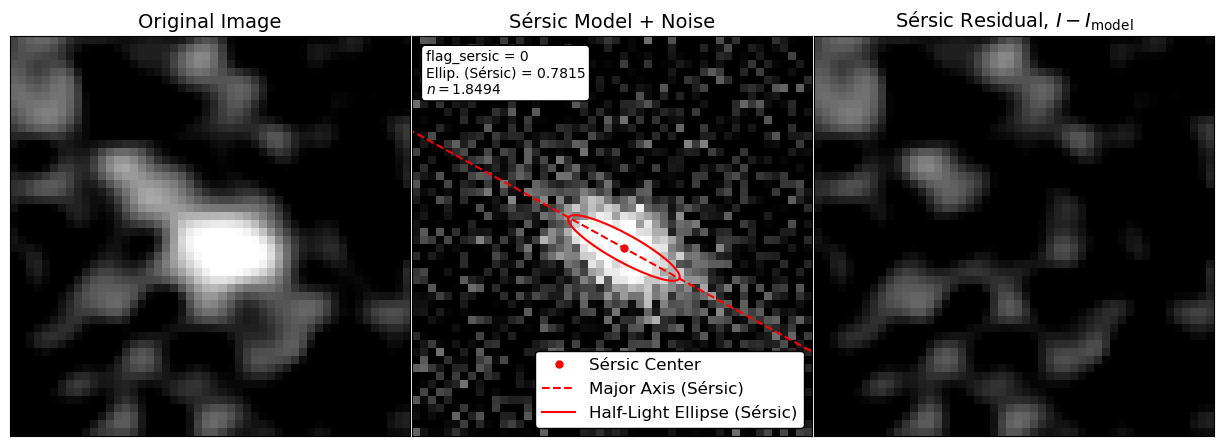

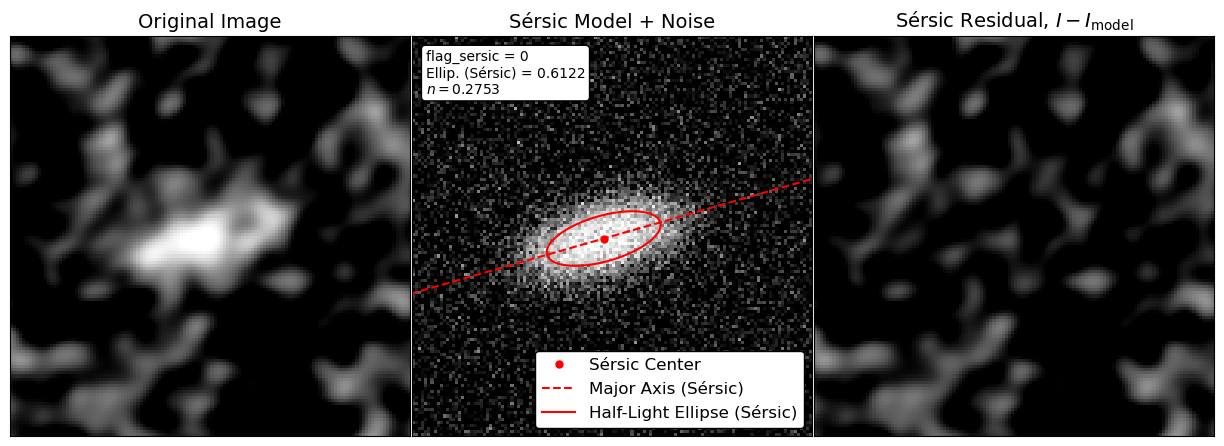

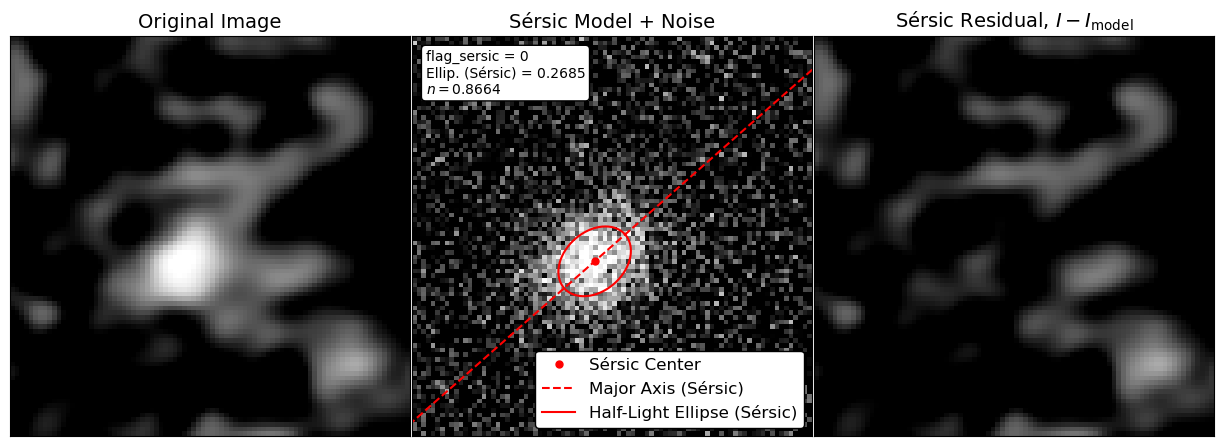

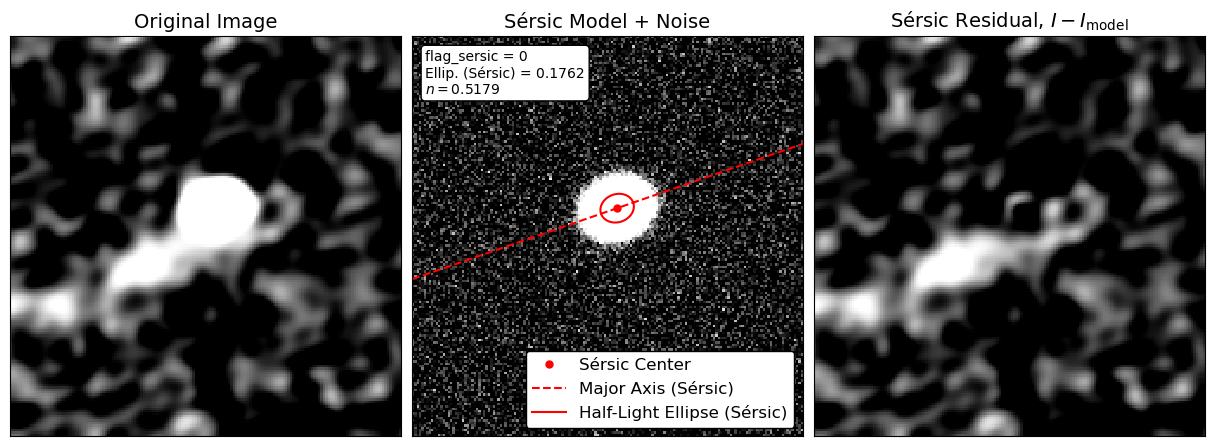

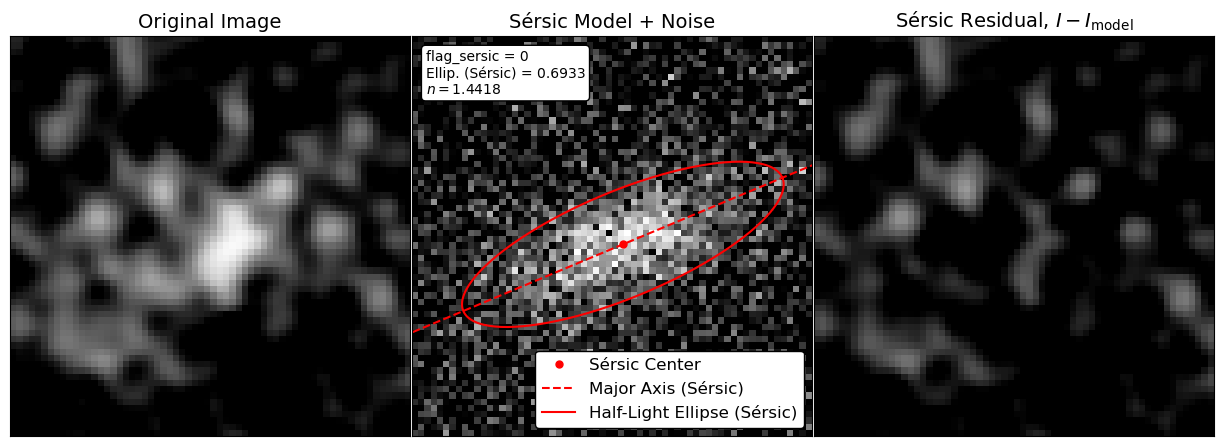

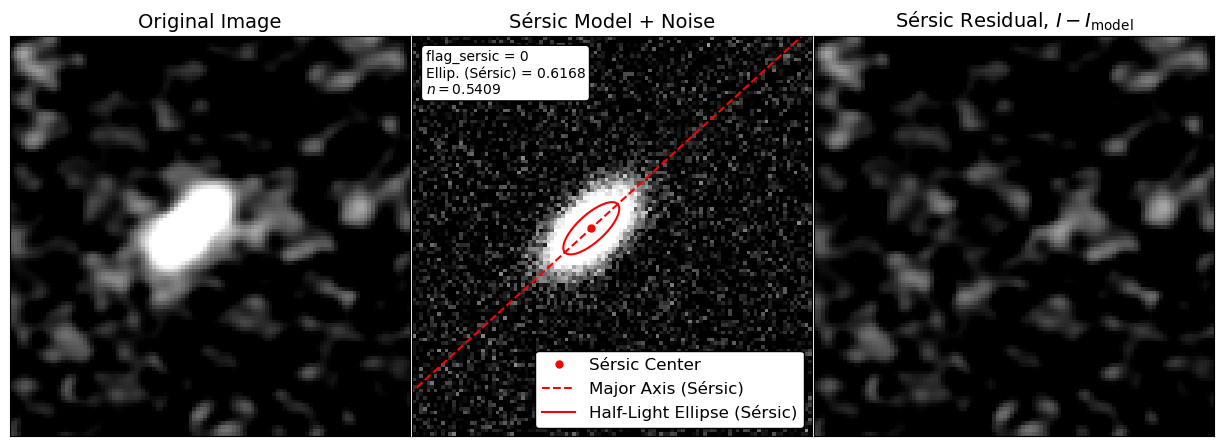

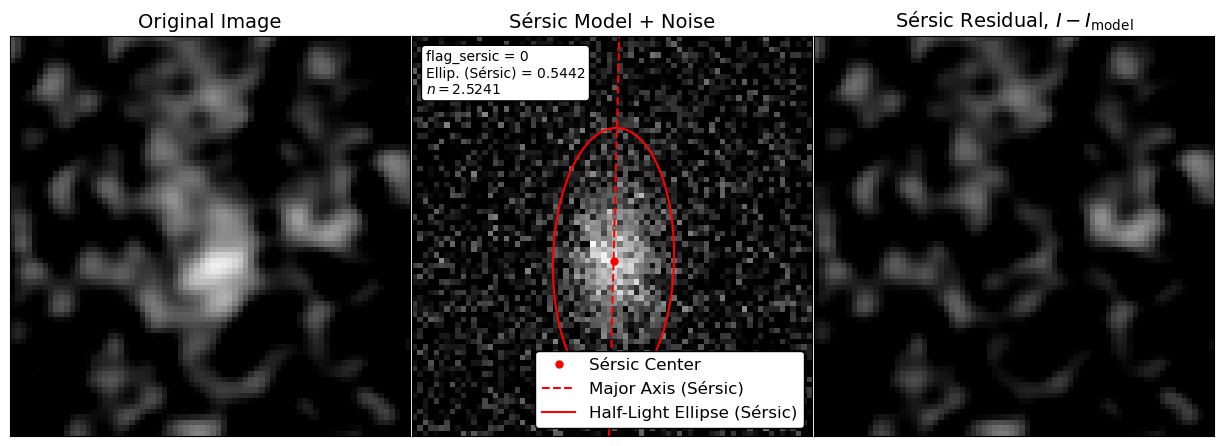

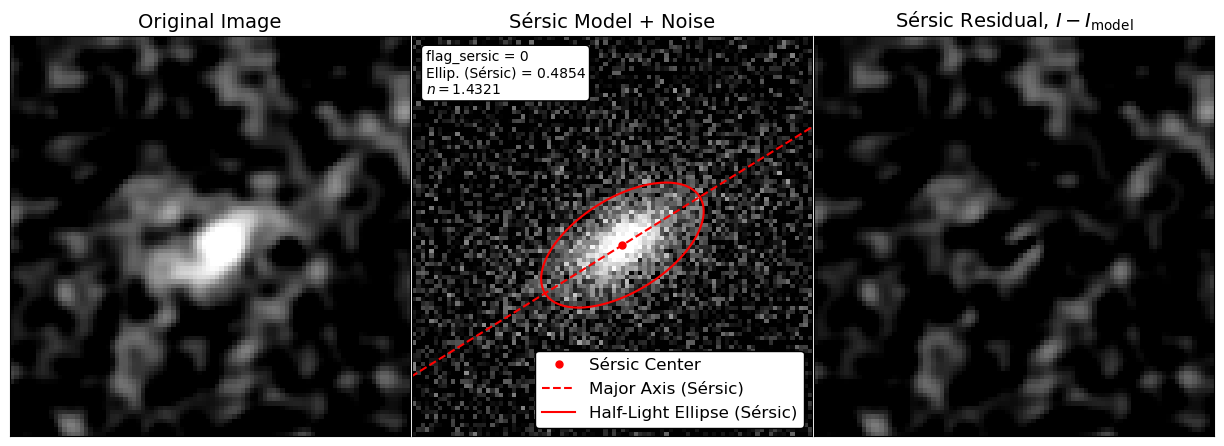

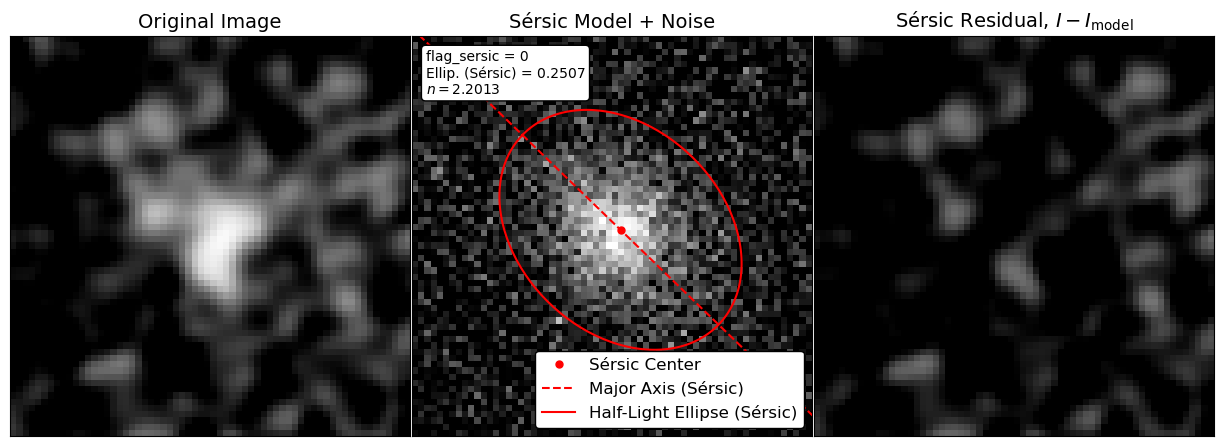

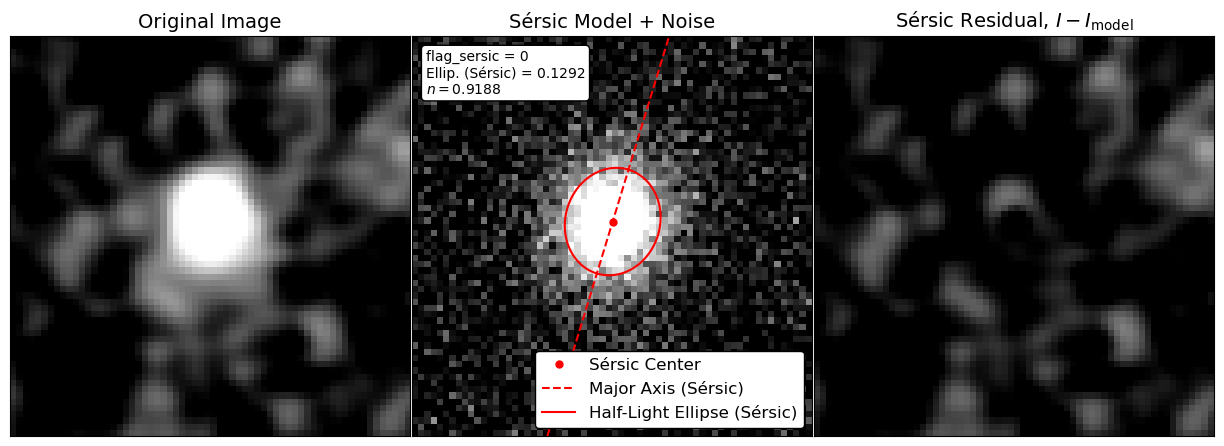

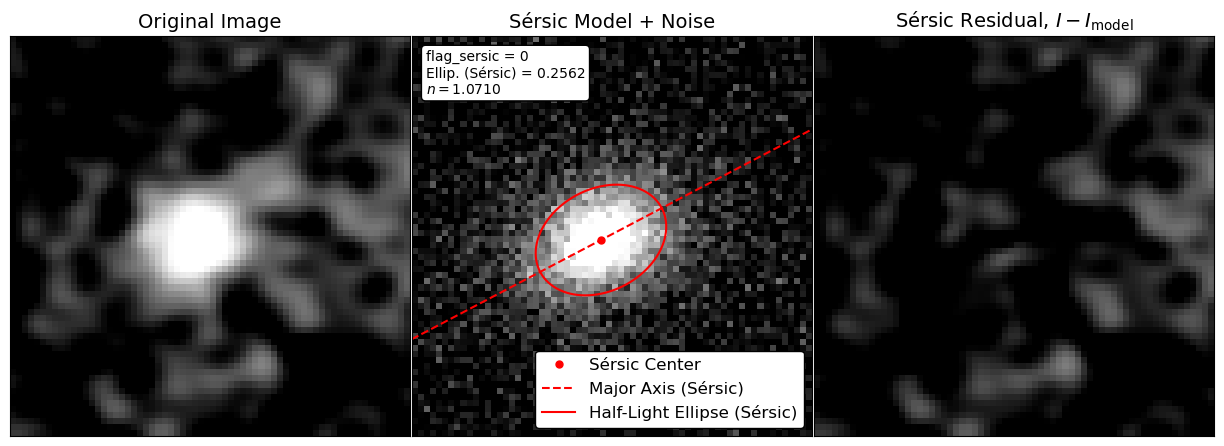

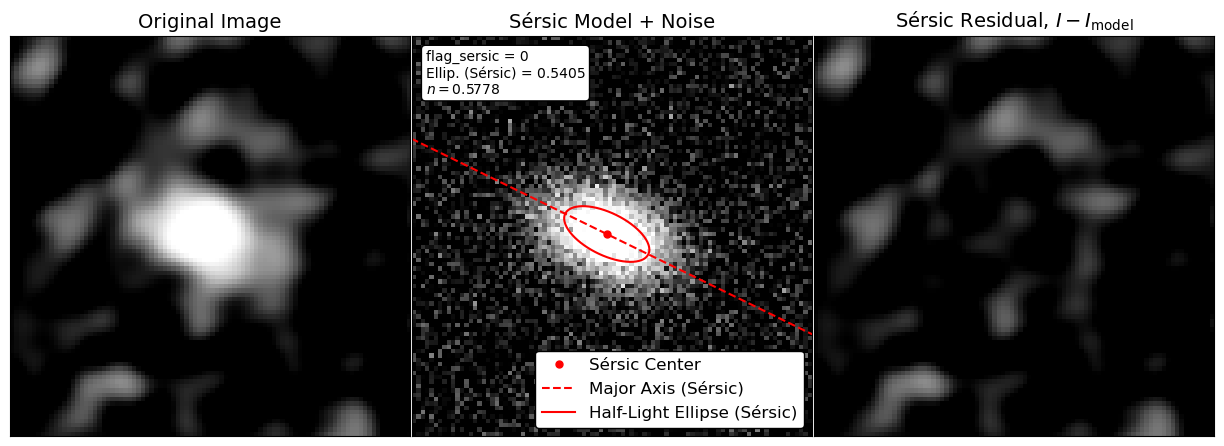

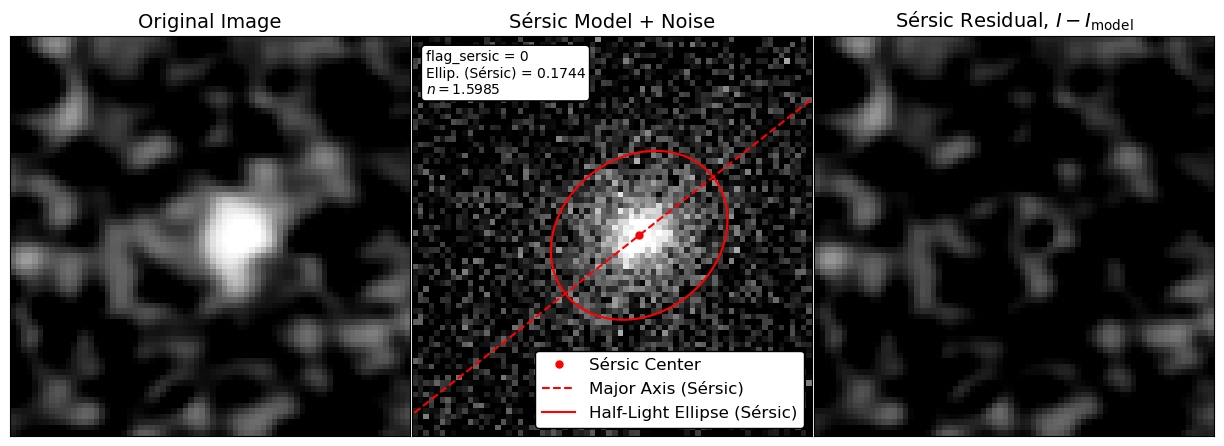

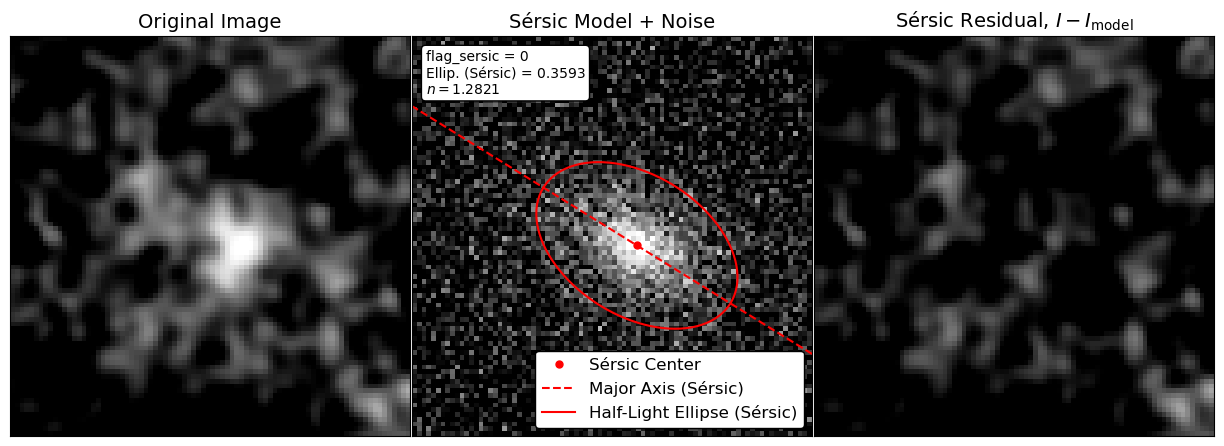

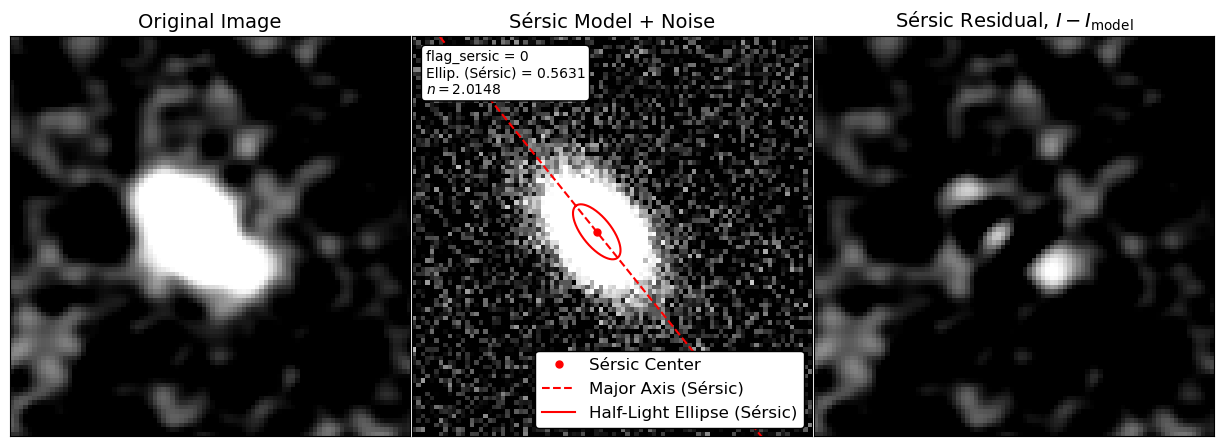

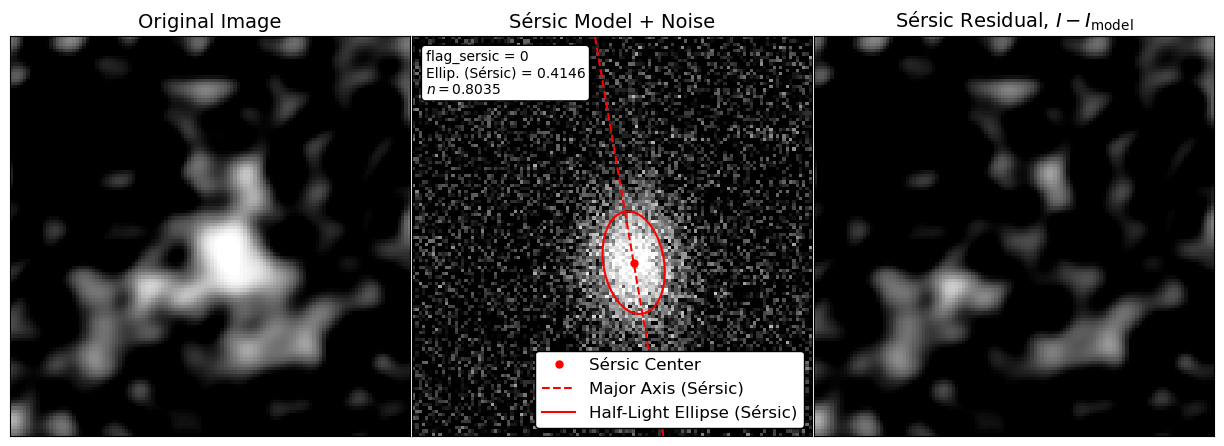

In [159]:
for x in fit_bcgs:
    if x in bbcgs:
        if x == 6:
            s = 12
        else:
            s = 8
        m1 = compute_sersic_beam(bcgs[x], s)
        sersic_n[bcgs[x]] = m1.sersic_n
        sersic_re[bcgs[x]] = m1.sersic_rhalf * 0.045
        fig = make_figure(m1)
        fig.savefig("plots/BCG-" + str(x+1)+ "_sersic.png", dpi = 300)
    elif x in nbbcgs:
        m2 = compute_sersic(bcgs[x])
        sersic_n[bcgs[x]] = m2.sersic_n
        sersic_re[bcgs[x]] = m2.sersic_rhalf * 0.045
        fig = make_figure(m2)
        fig.savefig("plots/BCG-" + str(x+1)+ "_sersic.png", dpi = 300)

In [160]:
sersic_dict =  {'bcgs': ['BCG-'+str(x+1) for x in fit_bcgs],
                'redshift': [z[x] for x in fit_bcgs],
                'spec_z': [spec_z[x] for x in fit_bcgs],
                'sersic_n': [sersic_n[bcgs[x]] for x in fit_bcgs],
                'sersic_re_arcsec': [sersic_re[bcgs[x]] for x in fit_bcgs]}
sersic_df = pd.DataFrame(sersic_dict)
sersic_df['sersic_re_kpc'] = sersic_df['sersic_re_arcsec'] * (cosmo.kpc_proper_per_arcmin(np.array(sersic_df['redshift'])).value)/60
sersic_df

,bcgs,redshift,spec_z,sersic_n,sersic_re_arcsec,sersic_re_kpc
0,BCG-1,0.535235,1,1.849356,0.355560,2.248622
1,BCG-6,0.790000,0,0.275304,0.860904,6.435602
2,BCG-7,0.806800,1,0.866450,0.392909,2.958349
3,BCG-8,0.813000,1,0.517899,0.323497,2.441977
4,BCG-9,0.849570,1,1.441762,1.244791,9.531200
5,BCG-11,0.916510,1,0.540903,0.442504,3.465021
6,BCG-12,0.918860,1,2.524134,1.105020,8.658989
7,BCG-13,1.040000,0,1.432111,0.943682,7.624459
8,BCG-16,1.193720,1,2.201270,0.982124,8.138026
9,BCG-18,1.380000,0,0.918778,0.390896,3.292395


In [90]:
sersic_df = pd.read_csv("data/bcg_info/sersic_df.csv", header = 0)

In [92]:
sersic_df = sersic_df[['bcgs', 'redshift', 'sersic_n', 'sersic_re_kpc']]

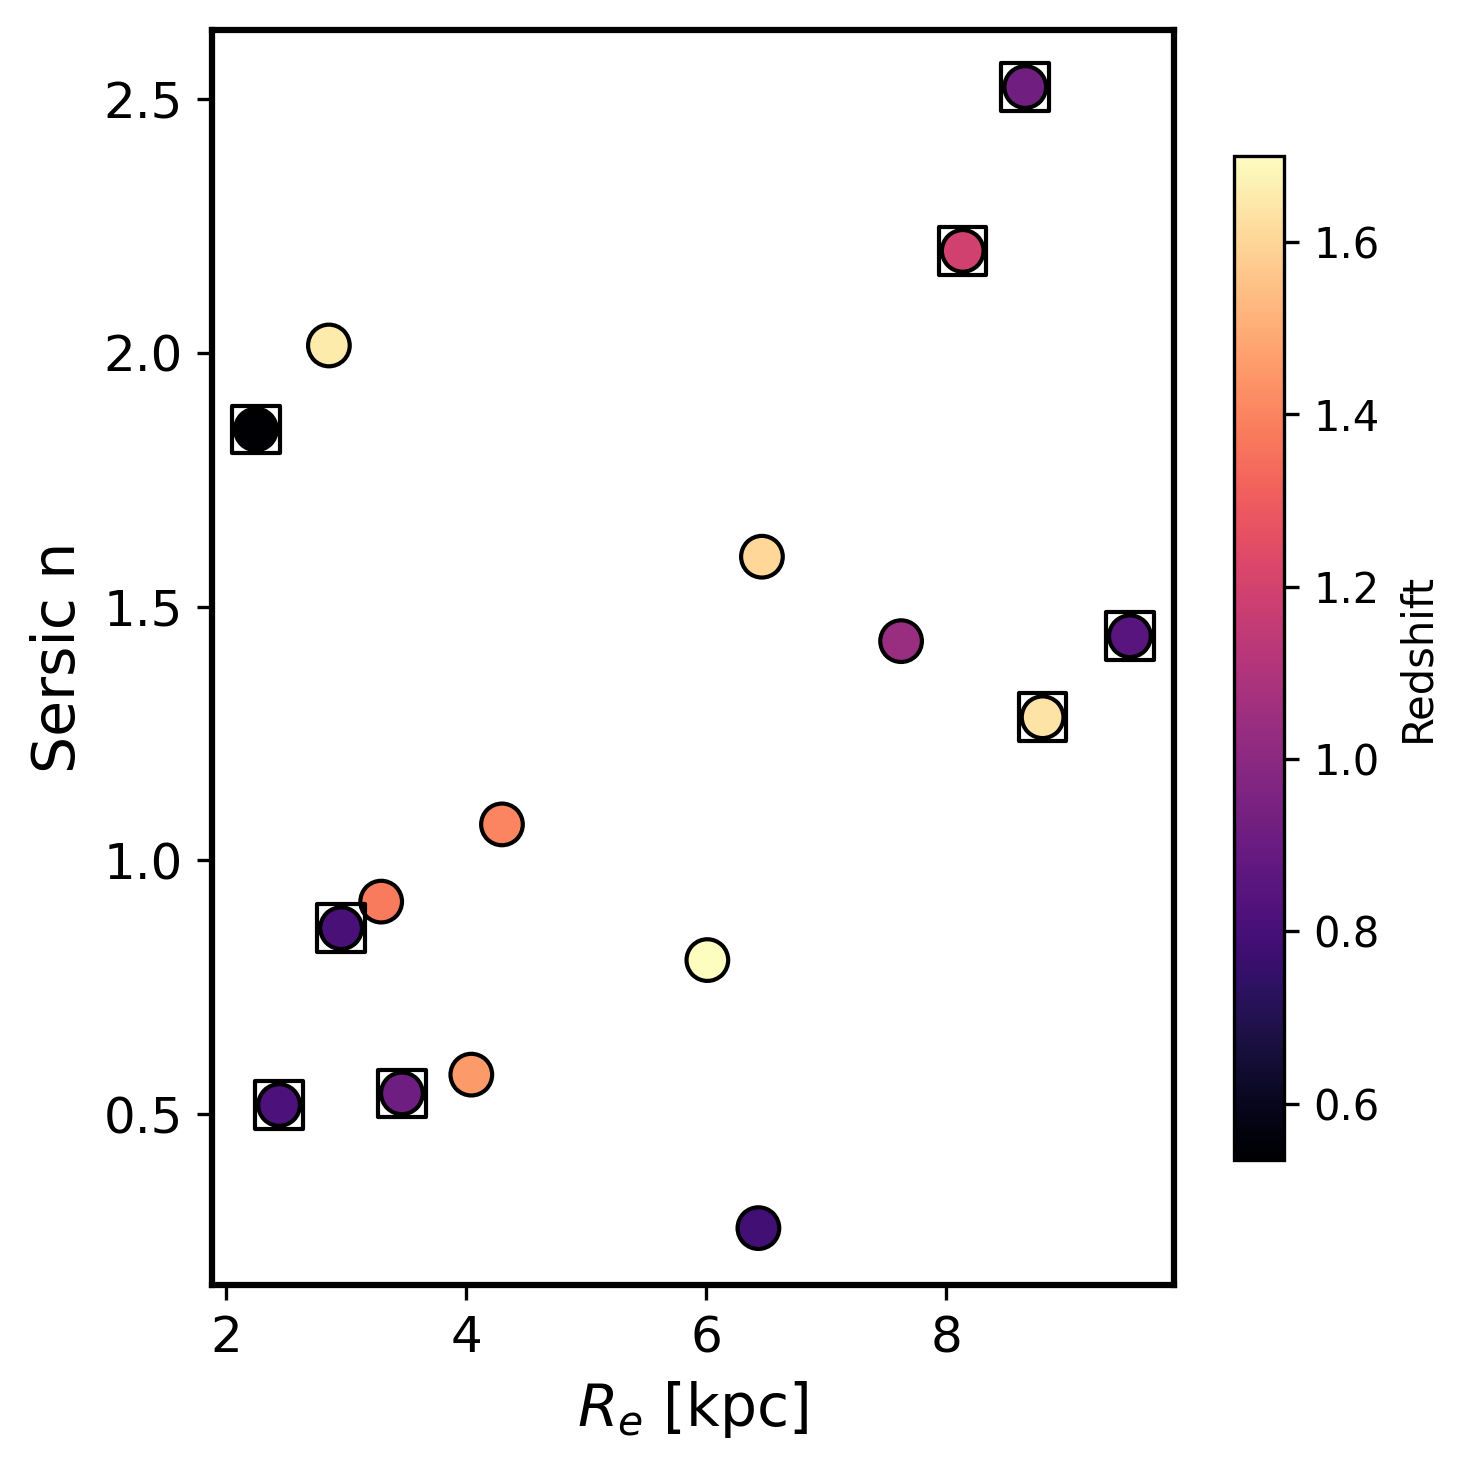

In [9]:
# Define a larger figure size suitable for publication
fig, ax = plt.subplots(figsize=(5,5), dpi = 300)

# Scatter plot with larger markers and black edges
im1 = ax.scatter(
    sersic_df['sersic_re_kpc'], 
    sersic_df['sersic_n'], 
    c=sersic_df['redshift'], 
    marker='o', 
    cmap='magma', 
    s=100,                # Even larger markers for clarity
    edgecolors='black', 
    linewidth=1        # Thin border around each circle marker
)

# Highlight points with spectroscopic redshift using square markers
mask_spec_z = sersic_df['spec_z'] == 1
ax.scatter(
    sersic_df.loc[mask_spec_z, 'sersic_re_kpc'], 
    sersic_df.loc[mask_spec_z, 'sersic_n'], 
    facecolors='none', 
    edgecolors='black', 
    marker='s', 
    s=130, label = '$z_{spec}$',               # Slightly larger than the circle markers
    linewidth=1        # Thicker border for the square markers
)

# Labels, titles, and fonts
ax.set_xlabel('$R_e$ [kpc]', fontsize=14)
ax.set_ylabel('Sersic n', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.legend(loc = 'upper left')

# Grid
# ax.grid(True, linestyle='--', which='both', alpha=0.7)

# Colorbar
cbar = plt.colorbar(im1, ax=ax,shrink=0.8)
cbar.set_label('Redshift')
# cbar.ax.tick_params(labelsize=12)

# ax.set_xscale('log')

# Adjust borders
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

# fig.savefig("plots/n_re_z.png", dpi = 300)

In [25]:
def sfr_mstar_df(bcg):

    path = glob.glob("/Users/arames52/Downloads/cigale-v2020.0/pcigale/data/*" + bcg + "*/out/results.fits")[0]
    data = Table(fits.open(path)[1].data)
    reqd = data[['id','bayes.sfh.sfr', 'bayes.sfh.sfr_err', 'bayes.stellar.m_star', 'bayes.stellar.m_star_err', 'best.reduced_chi_square']].to_pandas()
    reqd = reqd.rename(columns = {'bayes.sfh.sfr':"SFR", 'bayes.sfh.sfr_err':"SFR_err", 'bayes.stellar.m_star':"Stellar_mass", 'bayes.stellar.m_star_err':"Stellar_mass_err", "best.reduced_chi_square": "reduced_chi_square"})

    return reqd

In [26]:
def master_data(df):

    df['sSFR'] = df['SFR']/df['Stellar_mass']
    df['sSFR_err'] = (df['SFR']/df['Stellar_mass'])*np.sqrt((df['SFR_err']/df['SFR'])**2 + (df['Stellar_mass_err']/df['Stellar_mass'])**2)
    df['sSFR_gyr'] = np.array(df['sSFR'])*1e9
    df['sSFR_err_gyr'] = np.array(df['sSFR_err'])*1e9
    df['id'] = df['id'].str.replace('XMM_113','XMM-113')
    df['id'] = df['id'].str.replace('CDFS-19','CDFS19')
    df = pd.merge(df, bcg_info[['file_id', 'redshift']], left_on = 'id', right_on = 'file_id').drop('id', axis=1)
    df['Age'] = cosmo.age(df['redshift']).value
    df['sSFR_MS'] = 26 * np.array(df['Age'])**(-2.2)

    return df

In [27]:
df = pd.DataFrame()
for bcg in file_ids:
    
    reqd = sfr_mstar_df(bcg)
    df = pd.concat([df, reqd]).reset_index(drop=True)


df = master_data(df)
df = pd.merge(df, bcg_info[['id', 'ref_id', 'file_id', 'RA', 'Dec', 'spec_z', 'S/N']], on = 'file_id')
df = df[['id', 'ref_id','file_id', 'RA', 'Dec', 'S/N', 'redshift', 'spec_z', 
         'SFR', 'SFR_err', 'Stellar_mass', 'Stellar_mass_err', 
         'sSFR', 'sSFR_err', 'sSFR_gyr', 'sSFR_err_gyr', 'Age', 'sSFR_MS']]

In [112]:
sersic_df.to_csv("data/bcg_info/sersic_df.csv", index=False)

In [113]:
df.to_csv("data/bcg_info/sfr_df.csv", index=False)

In [114]:
sfr_df = df.copy()

In [93]:
sfr_df = pd.read_csv("data/bcg_info/sfr_df.csv",)

In [101]:
sfr_df_v2.columns

Index(['SFR', 'SFR_err', 'Stellar_mass', 'Stellar_mass_err', 'sSFR_gyr',
       'sSFR_err_gyr', 'reference id'],
      dtype='object')

In [108]:

sfr_df_v2 = sfr_df[['SFR', 'SFR_err', 'Stellar_mass', 'Stellar_mass_err','sSFR_gyr', 'sSFR_err_gyr']].copy()

sfr_df_v2['Stellar_mass'] = sfr_df_v2['Stellar_mass']/1e10
sfr_df_v2[ 'Stellar_mass_err'] = sfr_df_v2[ 'Stellar_mass_err']/1e10
sfr_df_v2 = sfr_df_v2.round(decimals=2)
sfr_df_v2['reference id'] = sfr_df['ref_id']
sfr_df_v2 = sfr_df_v2[['reference id','SFR', 'SFR_err', 'Stellar_mass', 'Stellar_mass_err', 'sSFR_gyr', 'sSFR_err_gyr']]

In [109]:
sfr_df_v2

,reference id,SFR,SFR_err,Stellar_mass,Stellar_mass_err,sSFR_gyr,sSFR_err_gyr
0,BCG-1,65.76,22.04,5.58,1.89,1.18,0.56
1,BCG-2,16.34,1.02,6.76,0.97,0.24,0.04
2,BCG-3,33.48,4.08,15.56,1.09,0.22,0.03
3,BCG-4,47.81,6.01,19.96,3.01,0.24,0.05
4,BCG-5,117.64,55.93,10.24,2.22,1.15,0.60
5,BCG-6,461.36,215.94,12.47,3.74,3.70,2.06
6,BCG-7,38.22,4.05,16.39,1.78,0.23,0.04
7,BCG-8,23.82,4.73,15.39,1.55,0.15,0.03
8,BCG-9,70.84,19.59,10.43,1.30,0.68,0.21
9,BCG-10,51.00,12.41,29.89,2.19,0.17,0.04


In [111]:
sersic_df = sersic_df[['bcgs', 'sersic_n', 'sersic_re_kpc']]
sersic_df = sersic_df.rename(columns = {'bcgs': 'reference id', 'sersic_n': ' Sersic n', 'sersic_re_kpc': ' Sersic R$_e$ [kpc]'})
sersic_df

,reference id,Sersic n,Sersic R$_e$ [kpc]
0,BCG-1,1.849356,2.248622
1,BCG-6,0.275304,6.435602
2,BCG-7,0.866450,2.958349
3,BCG-8,0.517899,2.441977
4,BCG-9,1.441762,9.531200
5,BCG-11,0.540903,3.465021
6,BCG-12,2.524134,8.658989
7,BCG-13,1.432111,7.624459
8,BCG-16,2.201270,8.138026
9,BCG-18,0.918778,3.292395


In [13]:
specz = sfr_df[sfr_df['spec_z'] == 1]

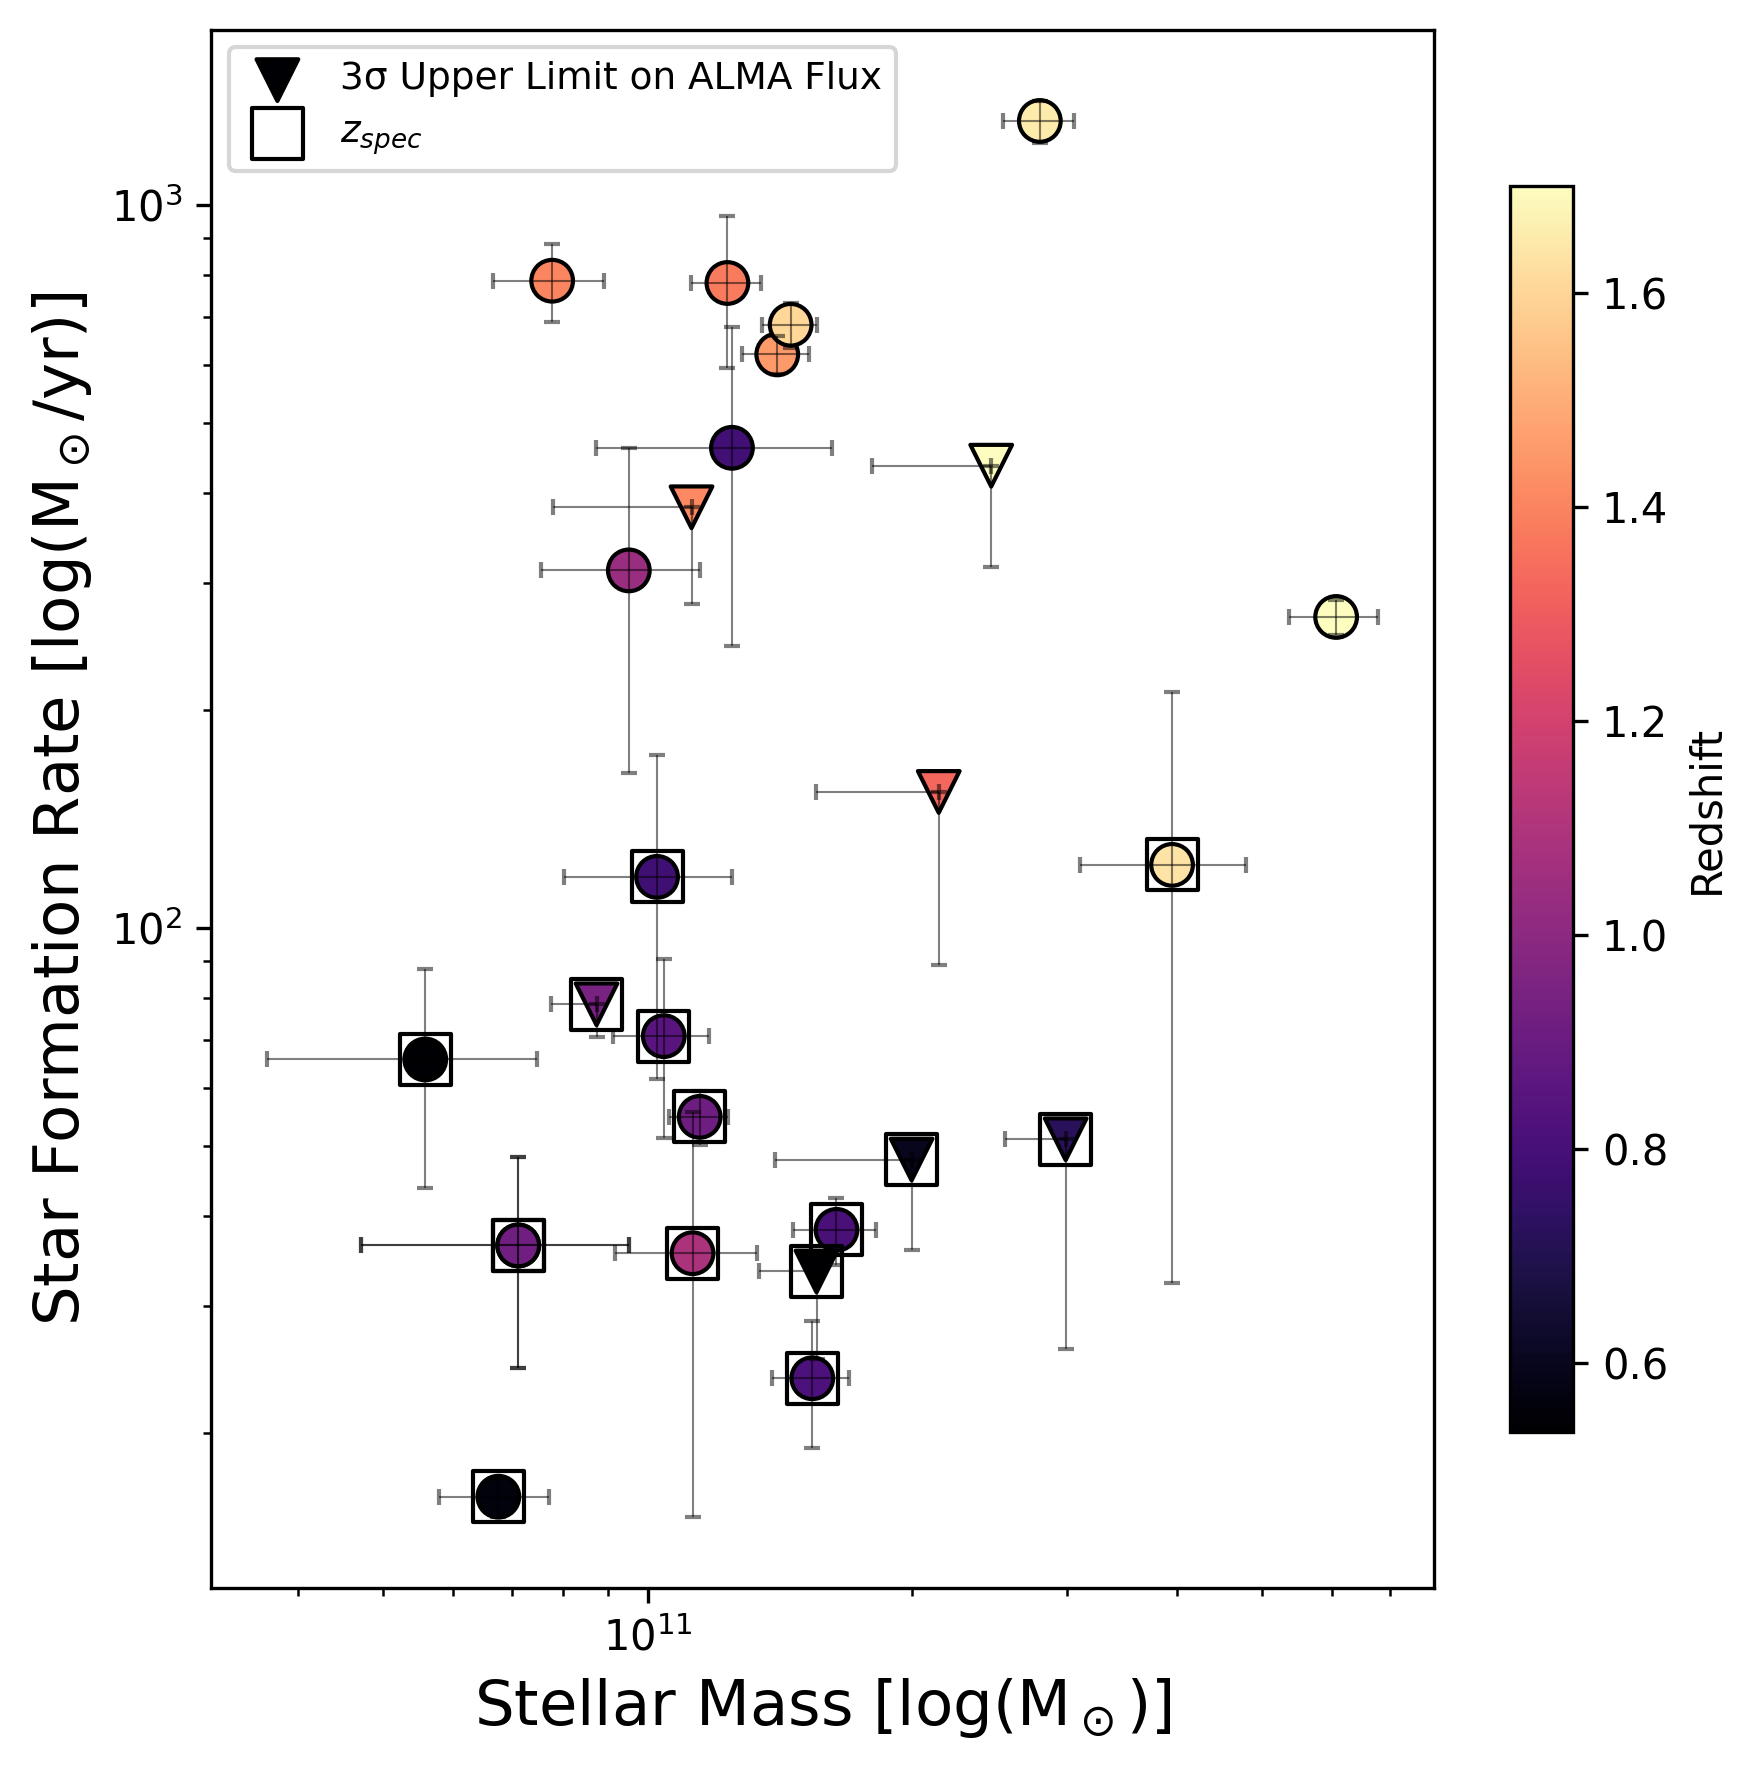

In [18]:
# BCGs that are non-detections
non_detections = ['BCG-3', 'BCG-4', 'BCG-10', 'BCG-14', 'BCG-17', 'BCG-20', 'BCG-26']

# Mask for non-detections in sfr_df
mask_non_detections = sfr_df['ref_id'].isin(non_detections)

# Create the updated plot with downward and leftward error bars for non-detections
# Plotting all other data points
mask_others = ~mask_non_detections
# Create the updated plot with correct downward and leftward error bars for non-detections
fig = plt.figure(figsize=(6, 6), dpi=300)

# Plotting all other data points
im1 = plt.scatter(sfr_df[mask_others]['Stellar_mass'], sfr_df[mask_others]['SFR'], marker='o', c=sfr_df[mask_others]['redshift'], cmap='magma', edgecolor='black', s=100)
plt.errorbar(sfr_df[mask_others]['Stellar_mass'], sfr_df[mask_others]['SFR'], xerr=sfr_df[mask_others]['Stellar_mass_err'], yerr=sfr_df[mask_others]['SFR_err'], ls='none', ecolor='black', alpha=0.5, capsize=2, elinewidth=0.5)

# Plotting non-detections with downward facing 'v' marker
plt.scatter(sfr_df[mask_non_detections]['Stellar_mass'], sfr_df[mask_non_detections]['SFR'], marker='v', c=sfr_df[mask_non_detections]['redshift'], cmap='magma', edgecolor='black', s=100, label='3σ Upper Limit on ALMA Flux')

# Corrected error bars for non-detections (down and left)
# Downward error bars for SFR
plt.errorbar(sfr_df[mask_non_detections]['Stellar_mass'], sfr_df[mask_non_detections]['SFR'] - sfr_df[mask_non_detections]['SFR_err'], yerr=sfr_df[mask_non_detections]['SFR_err'], ls='none', ecolor='black', alpha=0.5, capsize=2, elinewidth=0.5)
# Leftward error bars for Stellar Mass
plt.errorbar(sfr_df[mask_non_detections]['Stellar_mass'] - sfr_df[mask_non_detections]['Stellar_mass_err'], sfr_df[mask_non_detections]['SFR'], xerr=sfr_df[mask_non_detections]['Stellar_mass_err'], ls='none', ecolor='black', alpha=0.5, capsize=2, elinewidth=0.5)

# Plotting spec_z with square marker
plt.scatter(specz['Stellar_mass'], specz['SFR'], marker='s', color='black', facecolors='none', lw=1, s=150, label='$z_{spec}$')

# Additional plot settings
plt.xlabel("Stellar Mass [log(M$_\odot$)]", size=15)
plt.ylabel("Star Formation Rate [log(M$_\odot$/yr)]", size=15)
plt.yscale('log')
plt.xscale('log')
# plt.title("Stellar Mass vs SFR", size=16, weight='bold')
plt.colorbar(im1, label="Redshift", shrink=0.8)

# Reduced size legend
legend = plt.legend(fontsize='small')
plt.setp(legend.get_texts(), fontsize='9') # Reduce font size of the legend text
plt.setp(legend.get_title(), fontsize='9') # Reduce font size of the legend title

plt.grid(False)
plt.tight_layout()
plt.show()

fig.savefig("plots/sfr_mstar.png", dpi = 300)


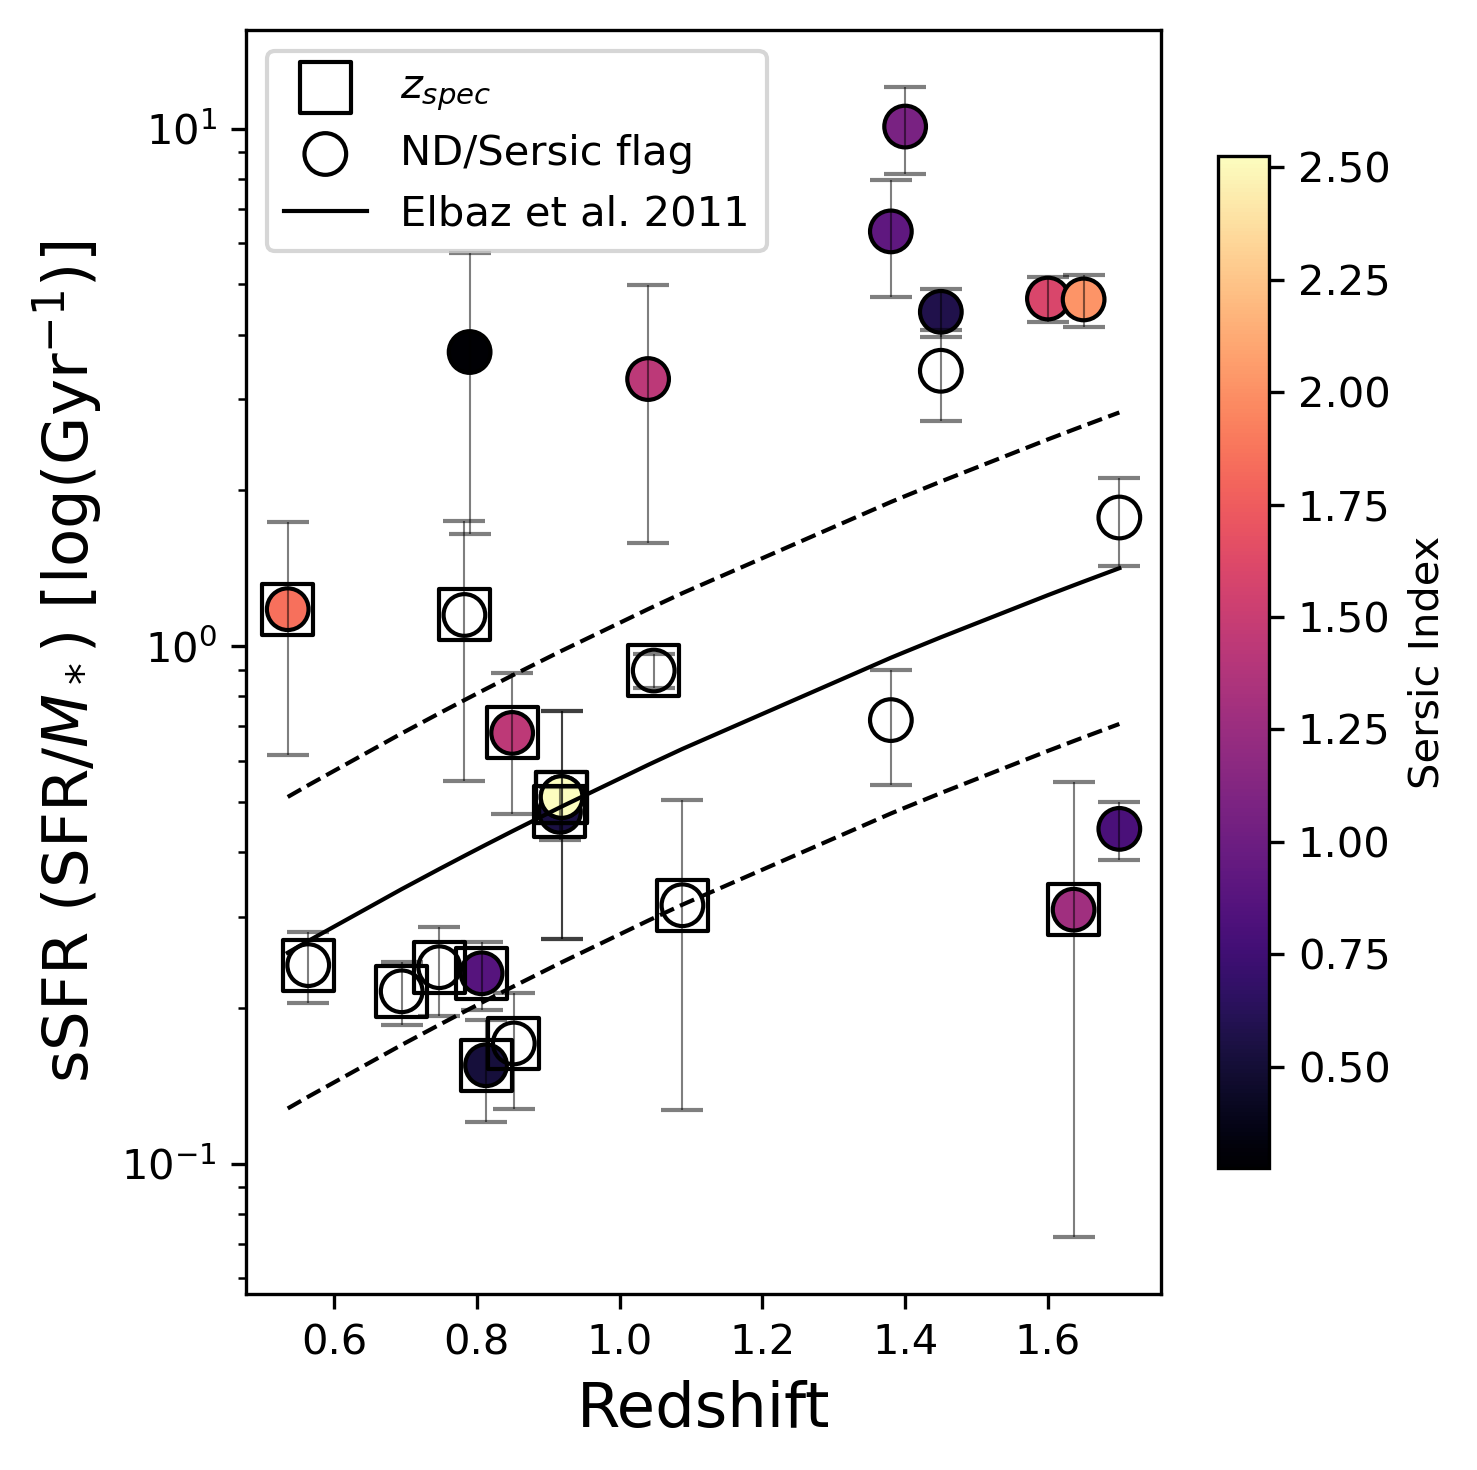

In [122]:
# Perform an outer merge between sfr_df and sersic_df
merged_df_outer = pd.merge(sfr_df, sersic_df[['bcgs', 'sersic_n']], left_on='ref_id', right_on='bcgs', how='outer')

# Drop the common 'bcgs' column after merging
merged_df_outer.drop('bcgs', axis=1, inplace=True)

# Extract rows with spec_z for square markers
specz_merged_outer = merged_df_outer[merged_df_outer['spec_z'] == 1]

# Mask for rows without a Sersic value
mask_no_sersic = merged_df_outer['sersic_n'].isna()

# Create the updated plot based on the new requirements
fig = plt.figure(figsize=(5, 5), dpi=300)

# Scatter plot color-coded by the Sersic index for all data points
im2 = plt.scatter(merged_df_outer['redshift'], merged_df_outer['sSFR_gyr'], c=merged_df_outer['sersic_n'], cmap='magma', edgecolor='black', marker = 'o', s=100)
plt.errorbar(merged_df_outer['redshift'], merged_df_outer['sSFR_gyr'], yerr=merged_df_outer['sSFR_err_gyr'], ls='none', ecolor='black', alpha=0.5, capsize=5, elinewidth=0.5)
plt.yscale('log')

# Square markers for BCGs with spec_z
plt.scatter(specz_merged_outer['redshift'], specz_merged_outer['sSFR_gyr'], marker='s', facecolors='none', edgecolors='black', s=150, label='$z_{spec}$', lw = 1)

# Unfilled markers for BCGs without a Sersic value
plt.scatter(merged_df_outer[mask_no_sersic]['redshift'], merged_df_outer[mask_no_sersic]['sSFR_gyr'], marker='o', facecolors='none', edgecolors='black', s=100, label='ND/Sersic flag')

# Additional plot settings
plt.ylabel("sSFR (SFR/$M_*$) [log(Gyr$^{-1}$)]", size=15)
plt.xlabel("Redshift", size=15)
plt.plot(sorted(merged_df_outer['redshift']), sorted(merged_df_outer['sSFR_MS']), color='black', linewidth=1, label='Elbaz et al. 2011')
plt.plot(sorted(merged_df_outer['redshift']), sorted(merged_df_outer['sSFR_MS'] * 2), color='black', ls="--", linewidth=1)
plt.plot(sorted(merged_df_outer['redshift']), sorted(merged_df_outer['sSFR_MS'] / 2), color='black', ls="--", linewidth=1)
# plt.title("Redshift Evolution of sSFR", size=16, weight='bold')
plt.colorbar(im2, label="Sersic Index", shrink=0.8)
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

fig.savefig("plots/ssfr_z_n.png", dpi = 300)

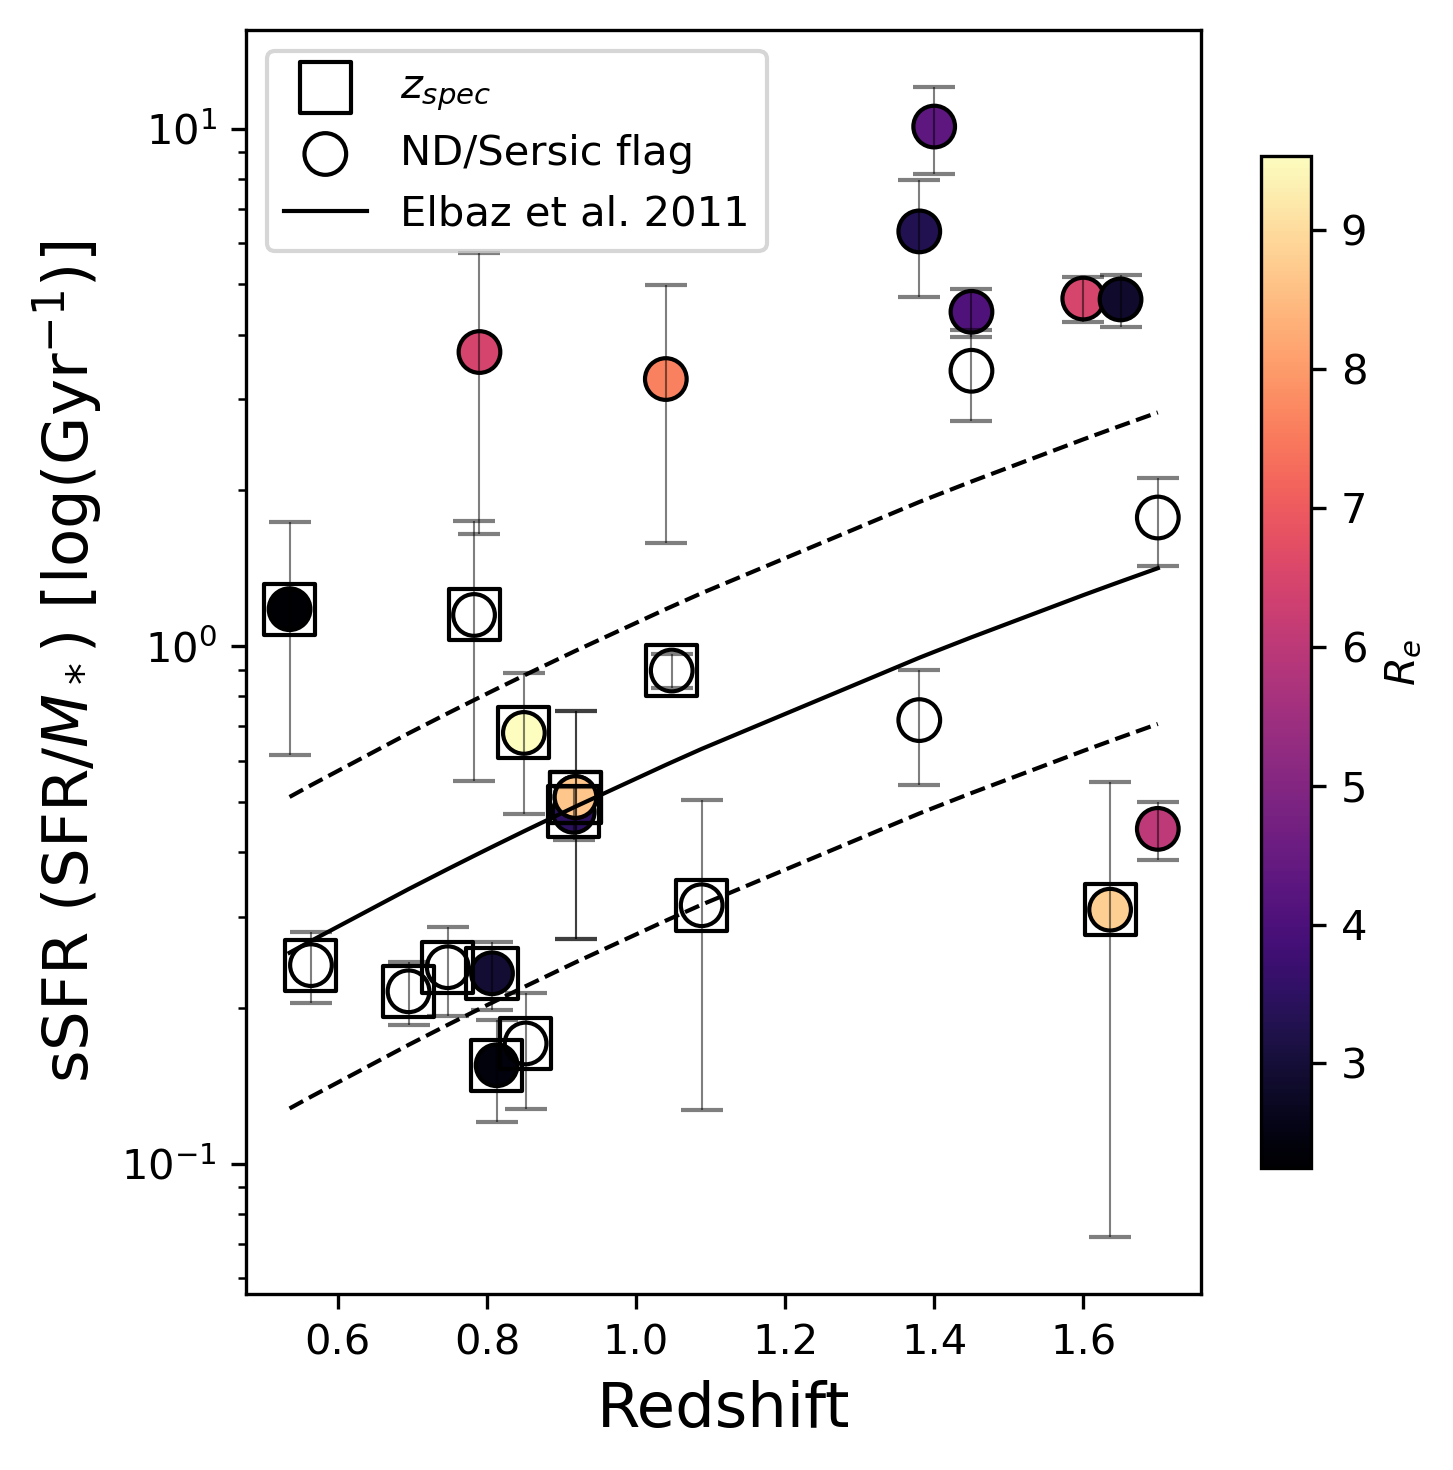

In [121]:
# Perform an outer merge between sfr_df and sersic_df
merged_df_outer = pd.merge(sfr_df, sersic_df[['bcgs', 'sersic_re_kpc']], left_on='ref_id', right_on='bcgs', how='outer')

# Drop the common 'bcgs' column after merging
merged_df_outer.drop('bcgs', axis=1, inplace=True)

# Extract rows with spec_z for square markers
specz_merged_outer = merged_df_outer[merged_df_outer['spec_z'] == 1]

# Mask for rows without a Sersic value
mask_no_sersic = merged_df_outer['sersic_re_kpc'].isna()

# Create the updated plot based on the new requirements
fig = plt.figure(figsize=(5, 5), dpi=300)

# Scatter plot color-coded by the Sersic index for all data points
im2 = plt.scatter(merged_df_outer['redshift'], merged_df_outer['sSFR_gyr'], c=merged_df_outer['sersic_re_kpc'], cmap='magma', edgecolor='black', marker = 'o', s=100)
plt.errorbar(merged_df_outer['redshift'], merged_df_outer['sSFR_gyr'], yerr=merged_df_outer['sSFR_err_gyr'], ls='none', ecolor='black', alpha=0.5, capsize=5, elinewidth=0.5)
plt.yscale('log')

# Square markers for BCGs with spec_z
plt.scatter(specz_merged_outer['redshift'], specz_merged_outer['sSFR_gyr'], marker='s', facecolors='none', edgecolors='black', s=150, label='$z_{spec}$', lw = 1)

# Unfilled markers for BCGs without a Sersic value
plt.scatter(merged_df_outer[mask_no_sersic]['redshift'], merged_df_outer[mask_no_sersic]['sSFR_gyr'], marker='o', facecolors='none', edgecolors='black', s=100, label='ND/Sersic flag')

# Additional plot settings
plt.ylabel("sSFR (SFR/$M_*$) [log(Gyr$^{-1}$)]", size=15)
plt.xlabel("Redshift", size=15)
plt.plot(sorted(merged_df_outer['redshift']), sorted(merged_df_outer['sSFR_MS']), color='black', linewidth=1, label='Elbaz et al. 2011')
plt.plot(sorted(merged_df_outer['redshift']), sorted(merged_df_outer['sSFR_MS'] * 2), color='black', ls="--", linewidth=1)
plt.plot(sorted(merged_df_outer['redshift']), sorted(merged_df_outer['sSFR_MS'] / 2), color='black', ls="--", linewidth=1)
# plt.title("Redshift Evolution of sSFR", size=16, weight='bold')
plt.colorbar(im2, label="$R_e$", shrink=0.8)
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()


In [38]:
imfit_df = pd.read_excel("data/imfit_output/imfit_df.xlsx")
bcg_properties_df = df[['ref_id', 'file_id', 'RA', 'Dec', 'S/N', 'redshift', 'spec_z',
       'SFR', 'SFR_err', 'Stellar_mass', 'Stellar_mass_err', 'sSFR',
       'sSFR_err', 'sSFR_gyr', 'sSFR_err_gyr', 'Age', 'sSFR_MS']].copy()
temp_df = pd.merge(bcg_properties_df, imfit_df[['id', 'pos_err', 'fwhm_maj', 'alma_ast_acc', 'z_ra', 'z_dec', 'sep_kpc', 'quad_err', 'scale_kpc_per_arcsec', 'quad_err_kpc']], left_on = 'file_id', right_on = 'id').drop('id', axis=1)
sersic_df = pd.read_csv("data/bcg_info/paper_table.csv")

master_data = pd.merge(temp_df, sersic_df[['id', 'Re_gaussian [kpc]', 'Re_sersic [kpc]', 'n']], left_on = 'file_id', right_on = 'id').drop('id', axis = 1)



In [43]:
# temp_df = temp_df.rename(columns = {'id':'ref_id'})
sersic_df = sersic_df.rename(columns = {'id':'ref_id'})
offset_df = pd.merge(temp_df[['ref_id', 'sep_kpc', 'quad_err_kpc', 'SFR', 'SFR_err', 'Stellar_mass', 'Stellar_mass_err',
'sSFR_gyr', 'sSFR_err_gyr']], sersic_df, on = 'ref_id')

In [19]:
offset_df = pd.read_csv("data/bcg_info/offset_df.csv", header=0)

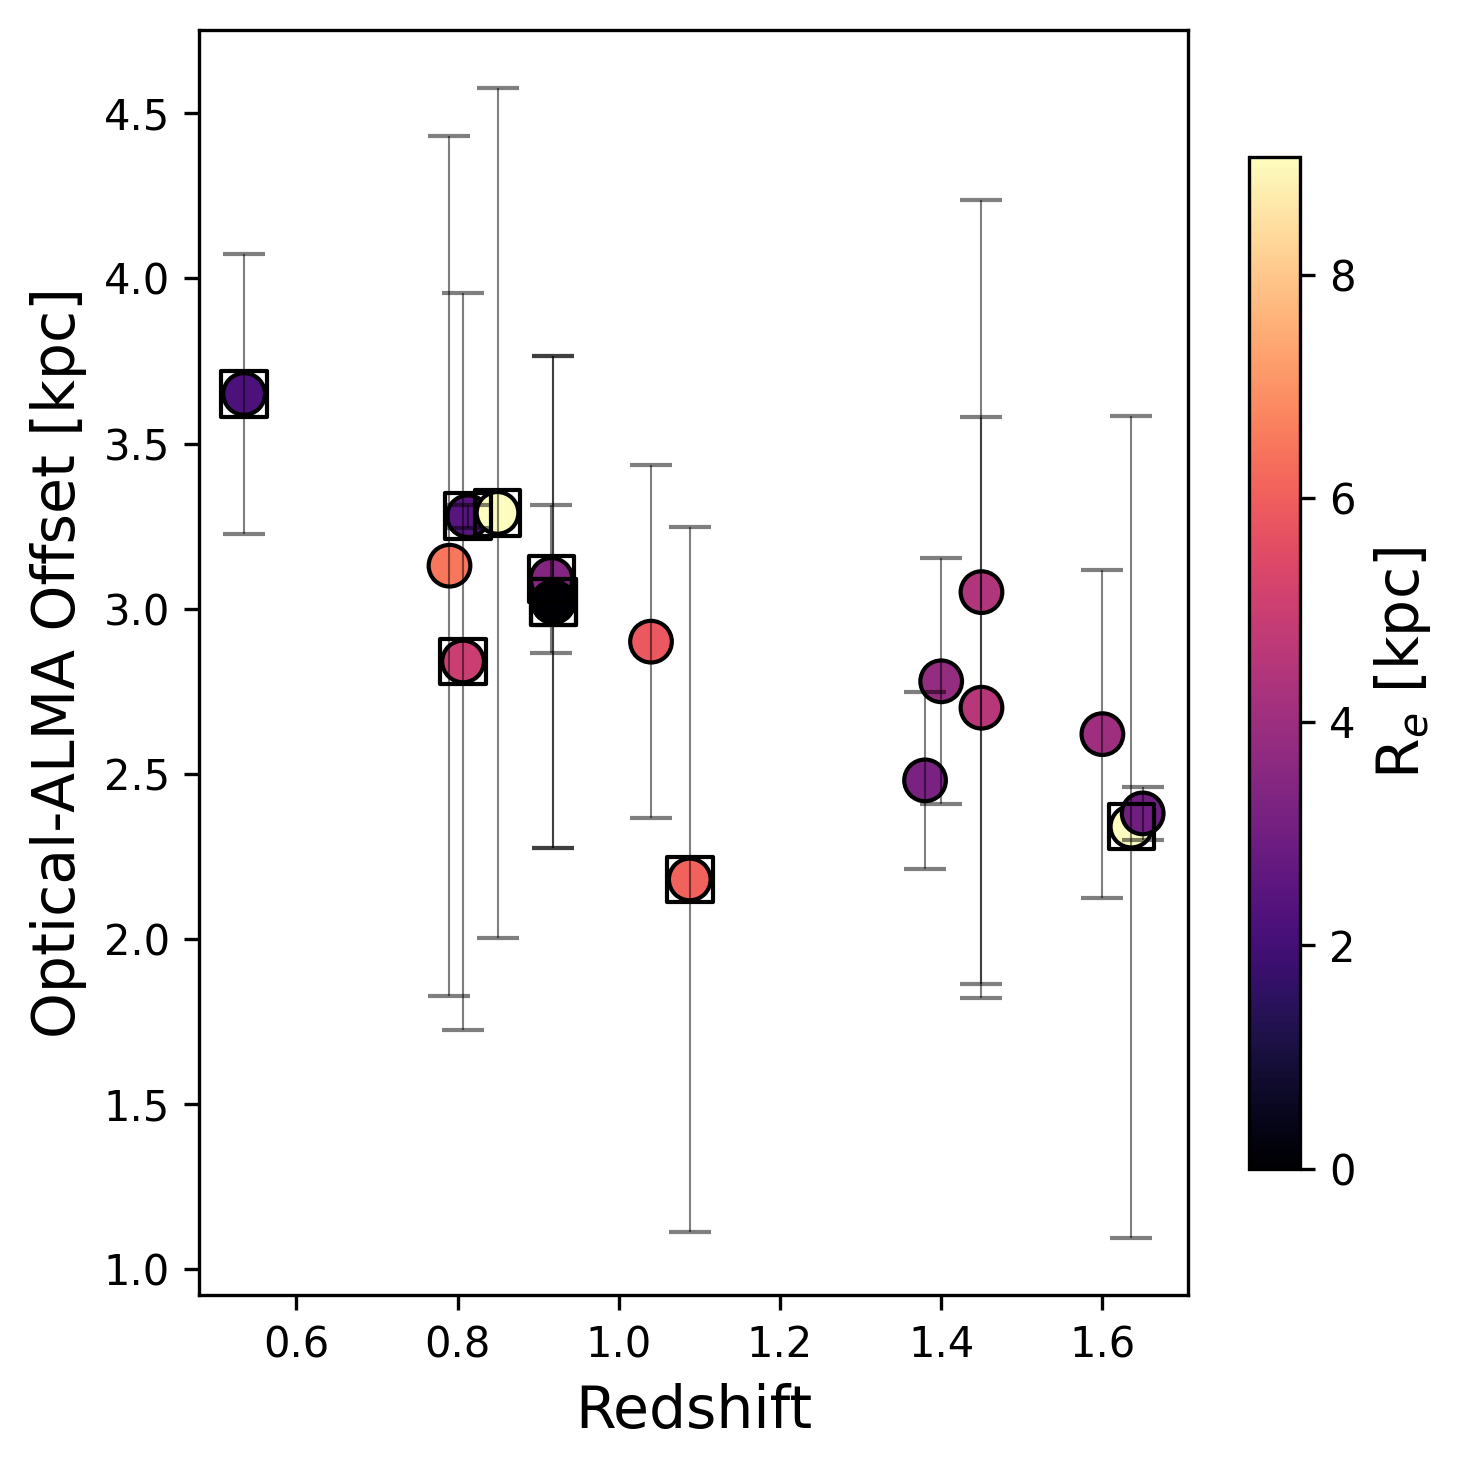

In [21]:
# Create the scatter plot
fig, ax = plt.subplots(figsize = (5,5), dpi=300)

specz = offset_df[offset_df['spec_z'] == 1]

# Scatter plot with y-error bars and color-coded by Re_sersic
sc = ax.scatter(offset_df['redshift'], offset_df['sep_kpc'], c=offset_df['Re_sersic [kpc]'], cmap='magma', edgecolor='black', s=100)
ax.errorbar(offset_df['redshift'], offset_df['sep_kpc'], yerr=offset_df['quad_err_kpc'], ls='none', ecolor='black', alpha=0.5, capsize=5, elinewidth=0.5)
ax.scatter(specz['redshift'], specz['sep_kpc'], marker='s', facecolor='none', edgecolor='black', s=120, label = '$z_{spec}$')
# Additional plot settings
ax.set_xlabel("Redshift", fontsize=14)
ax.set_ylabel("Optical-ALMA Offset [kpc]", fontsize=14)
# ax.set_title("Redshift vs Separation for BCGs", fontsize=16)
cb = plt.colorbar(sc, ax=ax, shrink = 0.8)
cb.set_label('R$_e$ [kpc]', fontsize=14)

plt.tight_layout()
plt.show()

fig.savefig("plots/offset.png", dpi=300)

In [189]:
# Given values
value_1 = 1.8
value_2 = 5

# Calculate the percentage by which value_1 is smaller than value_2
percentage_difference = ((value_2 - value_1) / value_2) * 100
percentage_difference

64.0

In [32]:
table1 = df[['id', 'ref_id', 'RA', 'Dec', 'redshift', 'spec_z', 'S/N']]
table1 = table1.rename(columns = {'RA':'RA (deg)', 'Dec': 'Dec (deg)', 'redshift': 'z (s/p)'})

def column_alter(row):

    if row['spec_z'] == 1:
        postfix = ' (s)'
    else:
        postfix = ' (p)'
    
    row['z (s/p)'] = str(round(row['z (s/p)'], 2)) + postfix

    row['RA (deg)'] = round(row['RA (deg)'],2)
    row['Dec (deg)'] = round(row['Dec (deg)'],2)

    return row

table1 = table1.apply(column_alter, axis=1)
table1.drop('spec_z', axis=1, inplace=True)

In [33]:
table1.to_csv("plots/table1.csv", index=False)

In [44]:
table2 = master_data[['ref_id', 'SFR', 'SFR_err', 'Stellar_mass', 'Stellar_mass_err', 'sSFR_gyr', 
                    'sSFR_err_gyr', 'n', 'Re_gaussian [kpc]', 'Re_sersic [kpc]', 'sep_kpc', 'quad_err_kpc']]

In [45]:
def alter_table2_columns(row):

    row['SFR'] = str(round(row['SFR'],2)) + ' $\pm$ ' + str(round(row['SFR_err'],2))
    row['Stellar_mass'] = row['Stellar_mass'] / 1e11
    row['Stellar_mass_err'] = row['Stellar_mass_err'] / 1e11
    row['Stellar_mass'] = str(round(row['Stellar_mass'],2)) + ' $\pm$ ' + str(round(row['Stellar_mass'],2))
    row['sSFR_gyr'] = str(round(row['sSFR_gyr'],2)) + ' $\pm$ ' + str(round(row['sSFR_err_gyr'],2))
    row['sep_kpc'] = str(round(row['sep_kpc'],2)) + ' $\pm$ ' + str(round(row['quad_err_kpc'],2))

    return row

In [46]:
table2 = table2.apply(alter_table2_columns, axis=1)
table2.drop(['SFR_err', 'Stellar_mass_err', 'sSFR_err_gyr', 'quad_err_kpc'], axis=1, inplace=True)
table2 = table2.rename(columns = {'SFR': 'SFR [$M_{\odot}/yr$]', 'Stellar_mass': '$M_* [M_{\odot}]$', 'sSFR_gyr' : 'sSFR [Gyr]',
                                  'Re_gaussian [kpc]': 'Re$_{gaussian}$ [kpc]', 'Re_sersic [kpc]':'Re_${sersic}$ [kpc]',
                                  'sep_kpc': 'Offset$_{SpARCS-ALMA} [kpc]'})

In [131]:
def plot_z_alma_offset():
    plt.figure(figsize=(5, 5), dpi=300)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    specz = master_data[master_data['spec_z'] == 1]
    im = plt.scatter(master_data['redshift'], master_data['sep_kpc'], c=master_data['Stellar_mass'], marker='o', edgecolor='black', linewidth=0.5, cmap='magma', s = 80)
    plt.scatter(specz['redshift'], specz['sep_kpc'], marker='s', facecolor='none', edgecolor='black', s=90, label = 'Spec_z')
    plt.errorbar(master_data['redshift'], master_data['sep_kpc'], yerr=np.array(master_data['quad_err_kpc']), ls='none', ecolor='black', alpha=0.5, solid_capstyle='projecting', capsize=1, elinewidth=0.5)
    plt.ylabel("SpARCS-ALMA$_{offset}$ [kpc]")
    plt.xlabel("Redshift")
    plt.legend(fontsize=5)
    cbar_ax = plt.colorbar(im, shrink=0.8)
    cbar_ax.set_label("$M_* [M_\odot]$", size=15)
    plt.title("Star formation offset from optical center", size=16, weight='bold')
    plt.tight_layout()
    plt.grid(False)
    plt.legend(frameon=True)
    # plt.savefig("plots/offset.png", bbox_inches='tight', dpi = 300)

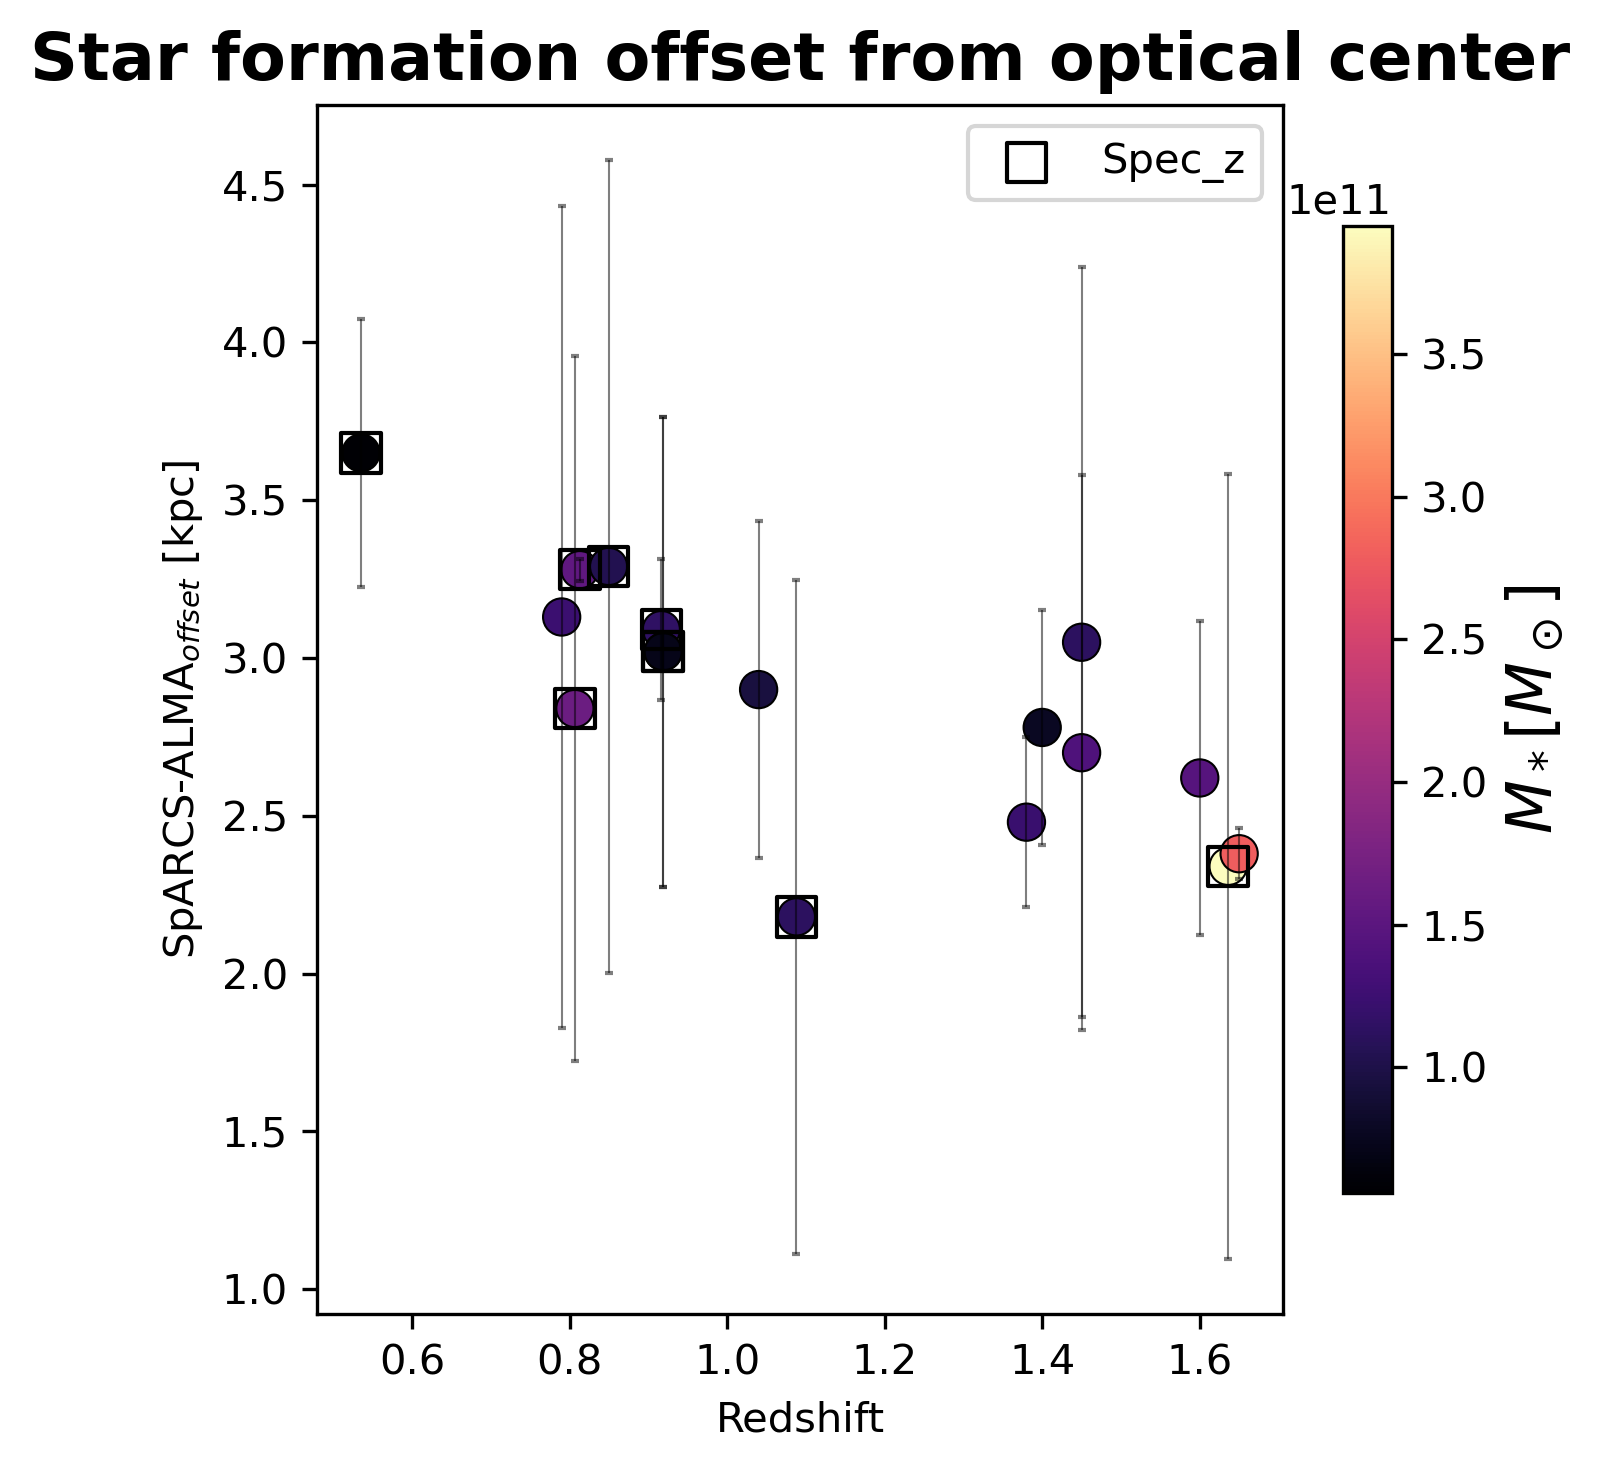

In [133]:
plot_z_alma_offset()

In [47]:
smg_sm = pd.read_csv("data/ancilliary_data/aless_smgs.txt", names = ["id", "MH", "z"], delim_whitespace=True)

def mh_to_mstar(mh):
    log_mstar = (ufloat(-0.393, 0.002) * mh) + ufloat(1.22, 0.04)
    return log_mstar

smg_morph = pd.read_csv("data/ancilliary_data/hodge_smg.txt", names=["id", "Re", "n"], 
                       delim_whitespace=True)
mh_arr = list(smg_sm['MH'])
hodge_smg = smg_sm.merge(smg_morph)
hodge_smg['mstar'] = mh_to_mstar(hodge_smg['MH'])
stellar_mass = []
stellar_mass_err = []
for ind, row in hodge_smg.iterrows():
    stellar_mass.append(row['mstar'].n)
    stellar_mass_err.append(row['mstar'].std_dev)
hodge_smg['stellar_mass'] = stellar_mass
hodge_smg['stellar_mass_err'] = stellar_mass_err
hodge_smg['Re_kpc'] = (cosmo.kpc_proper_per_arcmin(np.array(hodge_smg['z']))*(np.array(hodge_smg['Re']))/60).value
hodge_smg['rest_wave'] = 0.87/(1 + hodge_smg['z'])
hodge_smg['median_SFR'] = 500

In [63]:
# etg = pd.read_csv("/Users/arames52/Research/Data/mnras0382-0109-SD1.csv")
# etg = etg[etg['z'].between(0.5,1.7,inclusive = "both")]
# etg['re'] = etg['ae']*np.sqrt(1-etg['epsilon'])
# etg['re_kpc'] = (cosmo.kpc_proper_per_arcmin(np.array(etg['z']))*(np.array(etg['re']))/60).value
# etg['stellar_mass_log'] = np.log10(np.array(etg['stellar_mass'])*10**10)
# etg['rest_wave'] = 0.00081/(1+etg['z'])
hst_bcgs = pd.read_csv("data/ancilliary_data/table2.dat.txt", delim_whitespace=True, names = ["name", "class", "model", "mag", 
                                                                                                  "mean_sb", "re", "n", "b/a", "pa", 
                                                                                                   "align"])
hst_bcgs_tab1 = pd.read_csv("data/ancilliary_data/table1.dat.txt", delim_whitespace=True, names = ["name", "ra",
                                                    "dec", "z", "class", "inst", "filter", "scale", "color"])
hst_bcgs_mass = pd.read_csv("data/ancilliary_data/hst_bcgs_mass.dat.txt", delim_whitespace = True, names = ["name", "ra", "dec", "r_pos",
                                                                                                                    "M200", "E_M200", "e_M200", "Method", "r-M200",
                                                                                                                    "PAcl", "e_PAcl","r"])
hst_bcgs_mass = hst_bcgs_mass[["name", "M200", "e_M200"]]
hst_bcgs = hst_bcgs.merge(hst_bcgs_tab1, on = "name")
hst_bcgs = hst_bcgs.merge(hst_bcgs_mass, on = "name")
hst_bcgs = hst_bcgs[hst_bcgs['model'] == "Sersic"]
hst_bcgs = hst_bcgs[hst_bcgs['z'].between(0.5,1.7, inclusive = "both")]

In [230]:
hst_bcgs.to_csv("data/ancilliary_data/hst_bcgs_reduced.csv", index=False)

In [61]:
specz = master_data[master_data['spec_z'] == 1]
final_results = master_data.copy()

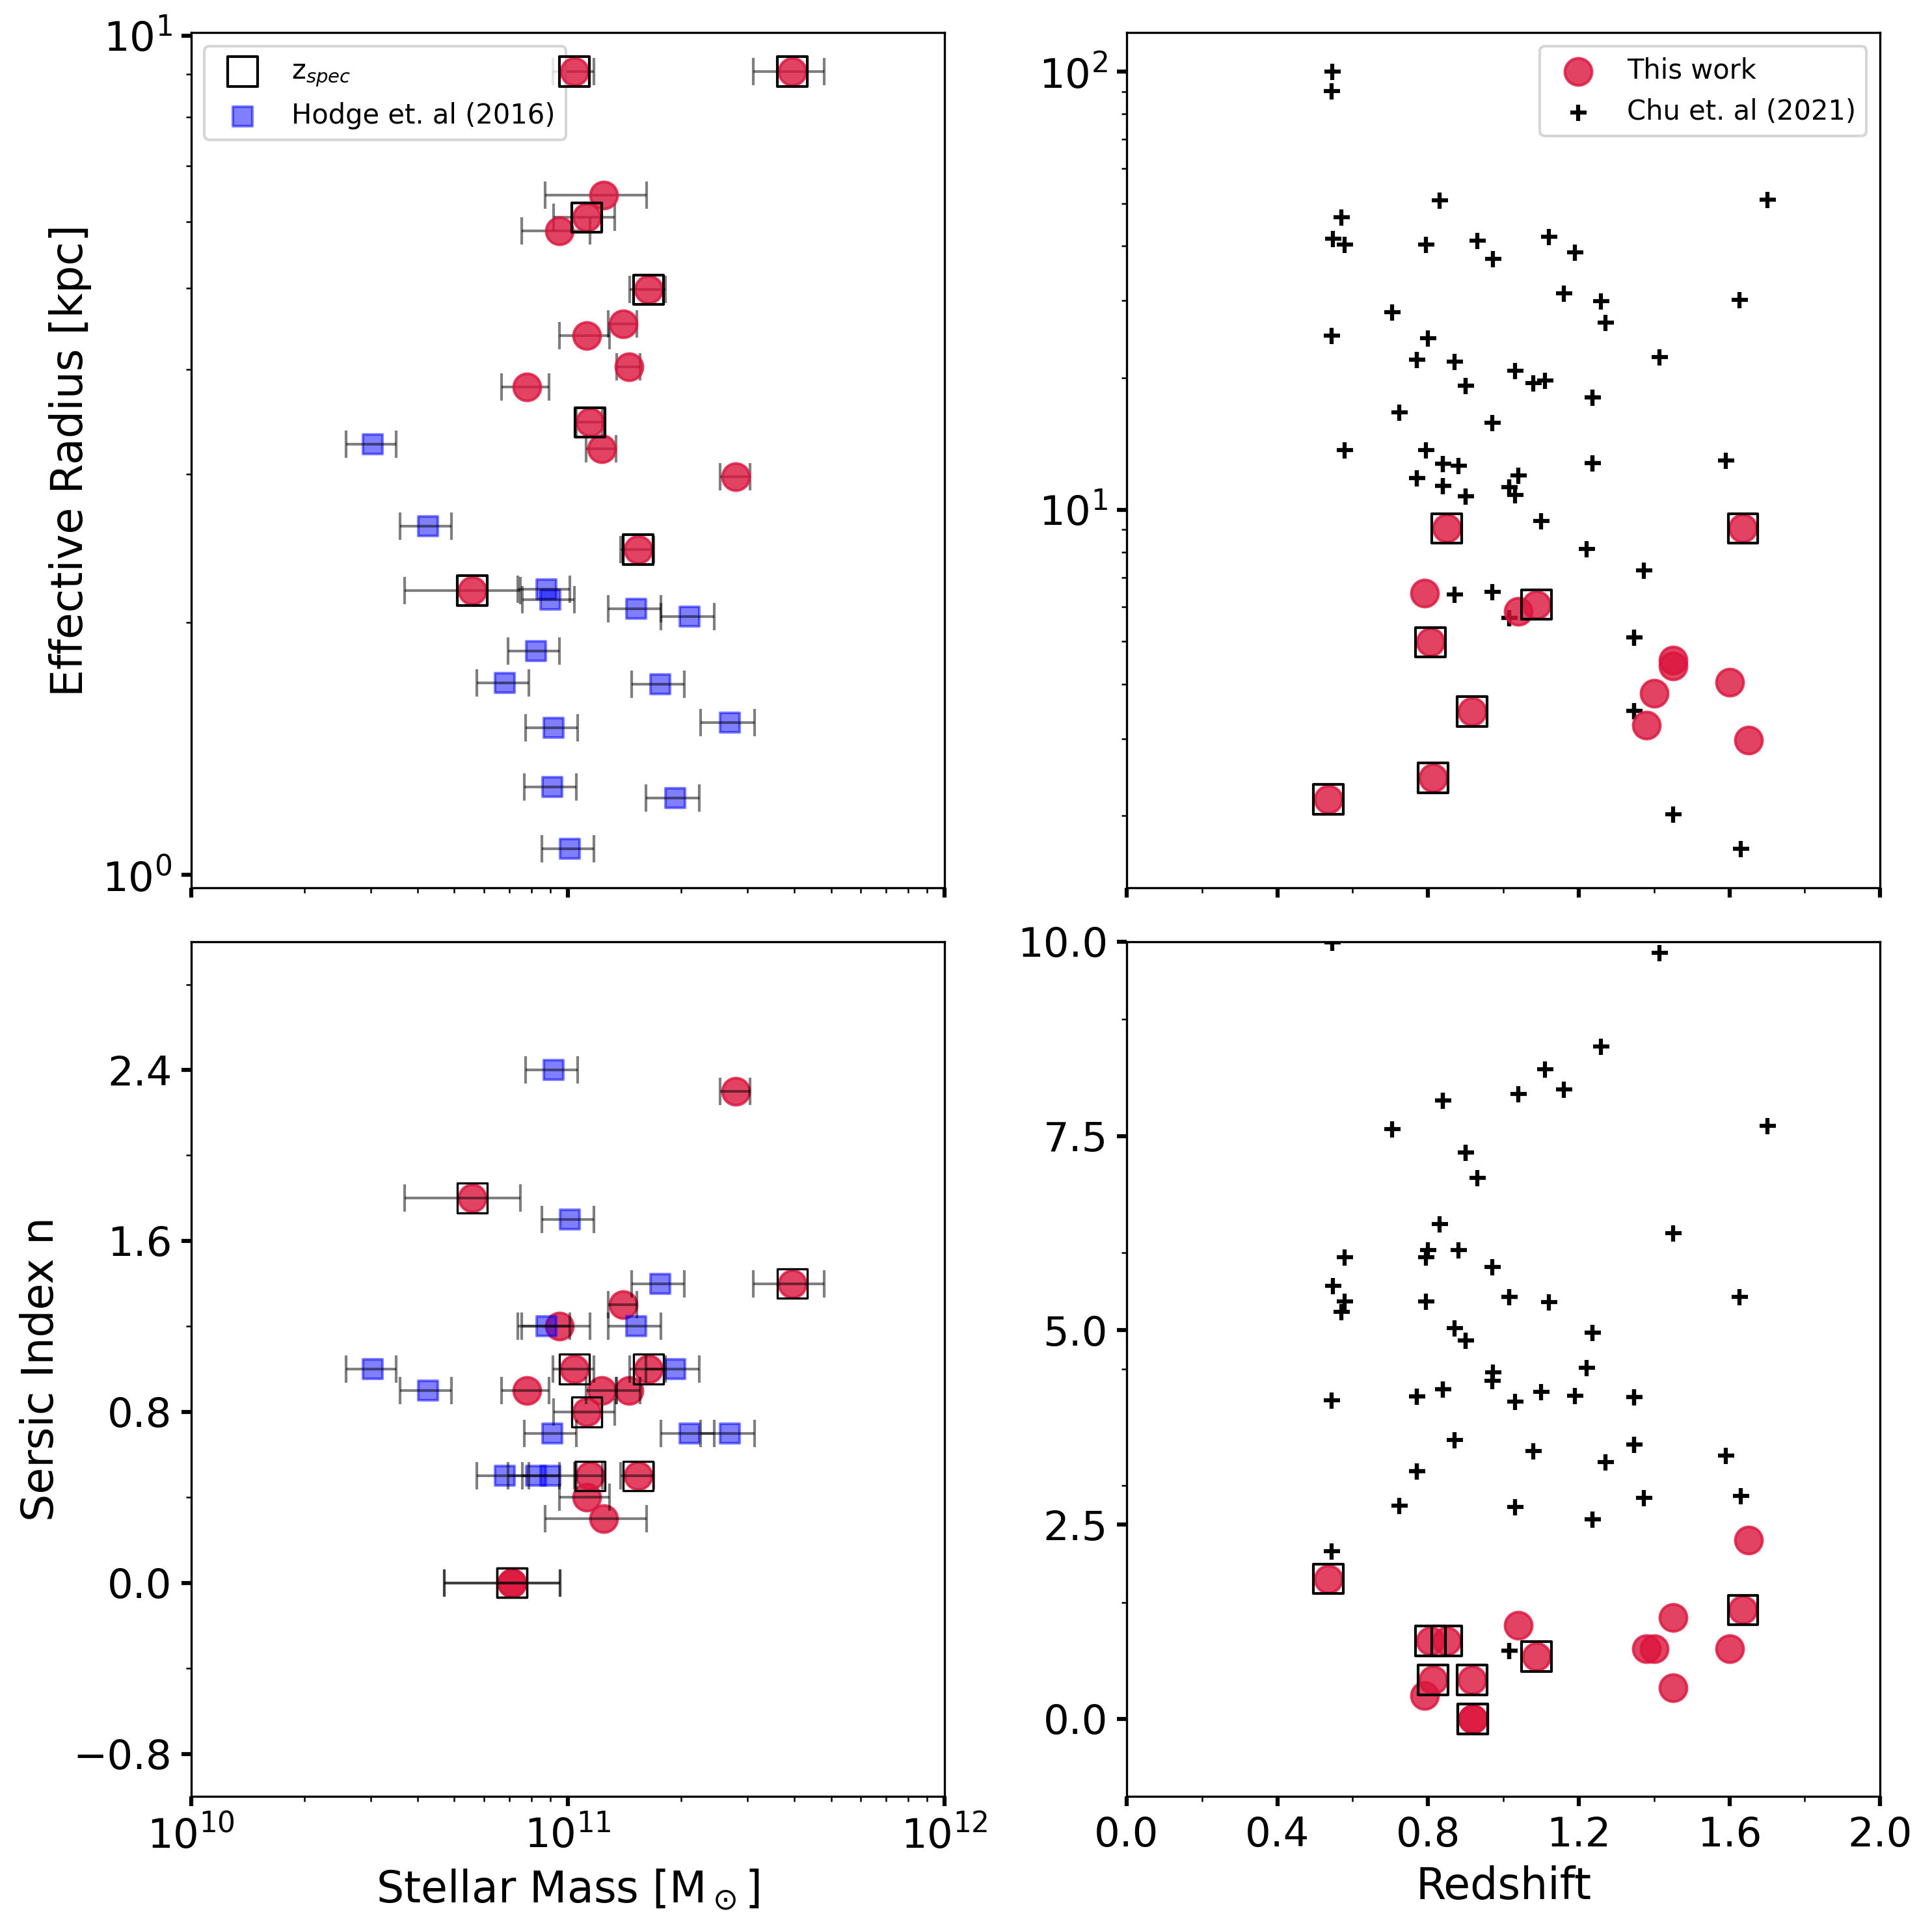

In [89]:
# Create a 2x2 figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=300,sharex='col')

# Increase x and y ticks
for ax in axs.flat:
    ax.tick_params(axis='both', which='both', labelsize=15)  # Increase font size of tick labels
    ax.xaxis.set_tick_params(width=1.5)  # Increase x-axis tick width
    ax.yaxis.set_tick_params(width=1.5)  # Increase y-axis tick width
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Set the number of major x-axis ticks
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Set the number of major y-axis ticks
    ax.xaxis.set_minor_locator(plt.MaxNLocator(10))  # Set the number of minor x-axis ticks
    ax.yaxis.set_minor_locator(plt.MaxNLocator(10))  # Set the number of minor y-axis ticks
    ax.grid(False)

# Subplot 1: Stellar Mass vs. Effective Radius (Left Top)
axs[0, 0].scatter(final_results['Stellar_mass'], final_results['Re_sersic [kpc]'], marker='o', s=100, color='crimson', zorder=10, alpha = 0.8)
axs[0, 0].scatter(specz['Stellar_mass'], specz['Re_sersic [kpc]'], marker='s', s=120, facecolor = 'none', edgecolor = 'black', zorder=10, label = "z$_{spec}$")
axs[0, 0].errorbar(final_results['Stellar_mass'], final_results['Re_sersic [kpc]'], xerr=final_results['Stellar_mass_err'], ls='none', ecolor='black', alpha=0.5, solid_capstyle='projecting', capsize=5, elinewidth=1)
axs[0, 0].scatter(10**hodge_smg['stellar_mass'], hodge_smg['Re_kpc'], marker='s', s=50, color='blue', alpha=0.5, label = "Hodge et. al (2016)")
axs[0, 0].errorbar(10**hodge_smg['stellar_mass'], hodge_smg['Re_kpc'], xerr=(10**(hodge_smg['stellar_mass'] + hodge_smg['stellar_mass_err']) - 10**(hodge_smg['stellar_mass'])), ls='none', ecolor='black', alpha=0.5, solid_capstyle='projecting', capsize=5, elinewidth=1)
# axs[0, 0].scatter(etg['stellar_mass'] * 10**10, etg['re_kpc'], color='grey', marker='.', alpha=0.5)

# axs[0, 0].axvline(x=5e11, ymin=0.5, ymax=0.6/axs[0, 0].get_ylim()[1], color='black', linestyle='--', linewidth=2, label='0.6 kpc')
# axs[0, 0].errorbar(final_results['Stellar_mass'].max() * 1.5, 0.6, yerr=0.1, fmt='|', color='black', markersize=5, capsize=10, elinewidth=1, capthick=1, label='0.6 kpc, Mean $Re_{gaussian}$ error')
# axs[0, 0].vlines(x=0.6, ymin=0, ymax=5, color='black', linestyle='-', linewidth=2, label='0.6 kpc error')
# axs[0, 0].errorbar(0.88, 0.05, yerr=0.1, fmt='|', color='black', markersize=10, capsize=10, elinewidth=2, capthick=2, label='0.6 kpc error', transform=axs[0, 0].transAxes)

axs[0, 0].set_ylabel("Effective Radius [kpc]", size=16)
# axs[0, 0].set_xlabel("Stellar Mass [M$_\odot$]", size=20)
axs[0, 0].set_xscale('log')
axs[0, 0].legend(scatterpoints=1, frameon=True)
axs[0, 0].set_yscale('log')
# axs[0, 0].set_ylim(10**-1)
axs[0, 0].set_xlim(10**10, 10**12)

# Subplot 2: Redshift vs. Effective Radius (Right Top)
axs[0, 1].scatter(final_results['redshift'], final_results['Re_sersic [kpc]'], marker='o', s=100, color='crimson', label="This work", zorder=10, alpha = 0.8)
axs[0, 1].scatter(specz['redshift'], specz['Re_sersic [kpc]'], marker='s', s=120, facecolor = 'none', edgecolor = 'black', zorder=10)
# axs[0, 1].scatter(hodge_smg['z'], hodge_smg['Re_kpc'], marker='s', s=50, color='blue', label="Hodge et al.(2016)", alpha=0.5)
# axs[0, 1].scatter(etg['z'], etg['re_kpc'], color='grey', marker='.', alpha=0.3, label="HST ETGs")
axs[0, 1].scatter(hst_bcgs['z'], hst_bcgs['re'], color='black', marker='+', label='Chu et. al (2021)')
# axs[0, 1].set_xlabel("Redshift", size=20)
axs[0, 1].legend(scatterpoints=1, frameon=True)
axs[0, 1].set_yscale('log')
# axs[0, 1].set_xscale('log')
axs[0, 1].set_xlim(2*10**-1)
# axs[1, 1].set_ylim(-1, 5)



# Subplot 3: Stellar Mass vs. Sersic Index n (Left Bottom)
axs[1, 0].scatter(final_results['Stellar_mass'], final_results['n'], marker='o', s=100, color='crimson', alpha = 0.8)
axs[1, 0].errorbar(final_results['Stellar_mass'], final_results['n'], xerr=final_results['Stellar_mass_err'], ls='none', ecolor='black', alpha=0.5, solid_capstyle='projecting', capsize=5, elinewidth=1)
axs[1, 0].scatter(specz['Stellar_mass'], specz['n'], marker='s', s=120, facecolor = 'none', edgecolor = 'black', lw=0.8, label='Spec z')
axs[1, 0].scatter(10**hodge_smg['stellar_mass'], hodge_smg['n'], marker='s', s=50, color='blue', alpha=0.5)
axs[1, 0].errorbar(10**hodge_smg['stellar_mass'], hodge_smg['n'], xerr=(10**(hodge_smg['stellar_mass'] + hodge_smg['stellar_mass_err']) - 10**(hodge_smg['stellar_mass'])), ls='none', ecolor='black', alpha=0.5, solid_capstyle='projecting', capsize=5, elinewidth=1)
# axs[1, 0].scatter(etg['stellar_mass'] * 10**10, etg['n'], color='grey', marker='.', alpha=0.5)
axs[1, 0].set_ylabel("Sersic Index n", size=16)
axs[1, 0].set_xlabel("Stellar Mass [M$_\odot$]", size=16)
axs[1, 0].set_xscale('log')
# axs[1, 0].legend(scatterpoints=1, frameon=True)
# axs[1, 0].set_yscale('log')
axs[1, 0].set_xlim(10**10, 10**12)
axs[1, 0].set_ylim(-1, 3)

# Subplot 4: Redshift vs. Sersic Index n (Right Bottom)
axs[1, 1].scatter(final_results['redshift'], final_results['n'], marker='o', s=100, color='crimson', label="This work", alpha = 0.8)
axs[1, 1].scatter(specz['redshift'], specz['n'], marker='s', s=120, facecolor = 'none', edgecolor = 'black')
# axs[1, 1].scatter(hodge_smg['z'], hodge_smg['n'], marker='s', s=50, color='blue', label="SMGs", alpha=0.5)
# axs[1, 1].scatter(etg['z'], etg['n'], color='grey', marker='.', alpha=0.3, label="HST ETGs")
axs[1, 1].scatter(hst_bcgs['z'], hst_bcgs['n'], color='black', marker='+', label='HST BCGs')
axs[1, 1].set_xlabel("Redshift", size=16)
# axs[1, 1].legend(scatterpoints=1, frameon=True)
# axs[1, 1].set_yscale('log')
# axs[1, 1].set_xscale('log')
axs[1, 1].set_xlim(0,2)
axs[1, 1].set_ylim(-1, 10)

# Adjust spacing between subplots
plt.tight_layout()

# fig.suptitle("Sersic Index and Effective Radius vs Stellar Mass and Redshift", weight = "bold", size = 16, y = 1.03)
# Show the plot
plt.show()

fig.savefig("plots/re_n_mstar_z.png", dpi = 300, bbox_inches = "tight")


In [196]:
sersic_df = pd.read_csv("/Volumes/T7/BCG_Dust_Continuum/data/bcg_info/sersic_df.csv")
sfr_df = pd.read_csv("/Volumes/T7/BCG_Dust_Continuum/data/bcg_info/sfr_df.csv")
hodge_smg_df = pd.read_csv("/Volumes/T7/BCG_Dust_Continuum/data/ancilliary_data/hodge_smg_reduced.csv")

merged_df = pd.merge(sersic_df, sfr_df, left_on='bcgs', right_on='ref_id', how='left')

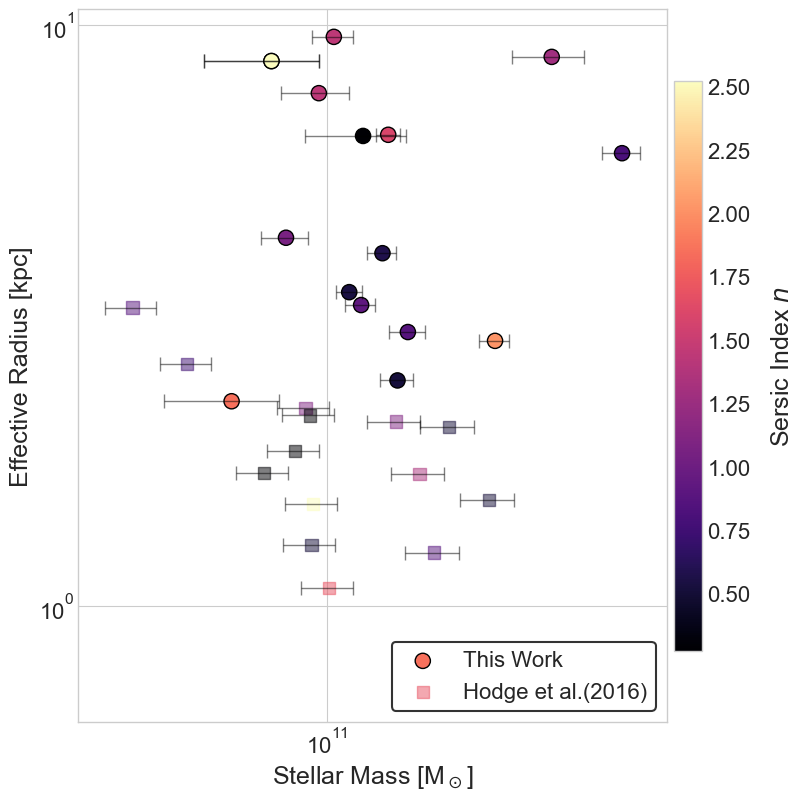

In [261]:
# # Set up the plot for publication quality
# plt.figure(figsize=(5,5), dpi = 300)
# plt.xlabel("Stellar Mass [M$_\odot$]", fontsize=14)
# plt.ylabel("Effective Radius [kpc]", fontsize=14)

# hodge_stellar_mass_error = (10**(hodge_smg_df['stellar_mass'] + hodge_smg_df['stellar_mass_err']) 
#                             - 10**(hodge_smg_df['stellar_mass']))

# # Plot data from merged_df
# sc1 = plt.scatter(merged_df['Stellar_mass'], merged_df['sersic_re_kpc'], 
#                   c=merged_df['sersic_n'], cmap='magma', 
#                   marker='o', label='This Work')
# plt.errorbar(merged_df['Stellar_mass'], merged_df['sersic_re_kpc'], 
#              xerr=merged_df['Stellar_mass_err'], fmt='o', color='gray', alpha=0.5, capsize=3)

# # Plot data from hodge_smg_reduced with 10^stellar_mass
# sc2 = plt.scatter(10**hodge_smg_df['stellar_mass'], hodge_smg_df['Re_kpc'], 
#                   c=hodge_smg_df['n'], cmap='magma', 
#                   marker='s', label='Hodge et al.(2016)')
# plt.errorbar(10**hodge_smg_df['stellar_mass'], hodge_smg_df['Re_kpc'], 
#              xerr=hodge_stellar_mass_error, fmt='s', color='gray', alpha=0.5, capsize=3)

# # Colorbar
# cbar = plt.colorbar(sc1, orientation='vertical')
# cbar.set_label('Sersic Index $n$', fontsize=14)

# # Legend
# plt.legend(fontsize=12)

# # Display the plot
# plt.tight_layout()
# plt.xscale("log")
# plt.yscale("log")
# plt.show()


# Set up the plot for enhanced publication quality
fig = plt.figure(figsize=(8,8))

# Use a clear background
# plt.style.use('seaborn-white')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust font sizes and label properties for clarity
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.title("Effective Radius vs Stellar Mass", fontsize=20)
plt.xlabel("Stellar Mass [M$_\odot$]", fontsize=18)
plt.ylabel("Effective Radius [kpc]", fontsize=18)

# Plot data from merged_df
sc1 = plt.scatter(merged_df['Stellar_mass'], merged_df['sersic_re_kpc'], 
                  c=merged_df['sersic_n'], cmap='magma', 
                  marker='o', edgecolors='k', s=120, label='This Work')
plt.errorbar(merged_df['Stellar_mass'], merged_df['sersic_re_kpc'], 
             xerr=merged_df['Stellar_mass_err'], ls='none', ecolor='black', alpha=0.5, solid_capstyle='projecting', capsize=5, elinewidth=1)

# Plot data from hodge_smg_reduced with 10^stellar_mass and updated error bars
sc2 = plt.scatter(10**hodge_smg_df['stellar_mass'], hodge_smg_df['Re_kpc'], 
                  c=hodge_smg_df['n'], cmap='magma', 
                  marker='s', alpha = 0.5, s=80, label='Hodge et al.(2016)')
plt.errorbar(10**hodge_smg_df['stellar_mass'], hodge_smg_df['Re_kpc'], 
             xerr=hodge_stellar_mass_error, ls='none', ecolor='black', alpha=0.5, solid_capstyle='projecting', capsize=5, elinewidth=1)

# Colorbar with enhanced readability
cbar = plt.colorbar(sc1, orientation='vertical', pad=0.01, shrink = 0.8)
cbar.set_label('Sersic Index $n$', fontsize=18, labelpad=15)
cbar.ax.tick_params(labelsize=16)

# Legend with enhanced readability
legend = plt.legend(fontsize=16, loc='lower right', frameon=True, edgecolor='k')
legend.get_frame().set_linewidth(1.5)

# Remove top and right spines for a cleaner look
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

# Display the plot with a tight layout
plt.tight_layout()
plt.xscale("log")
plt.yscale("log")
plt.ylim(10**(-0.2))
plt.show()
fig.savefig("plots/hodge_bcgs.png", dpi = 300, bbox_inches = "tight")

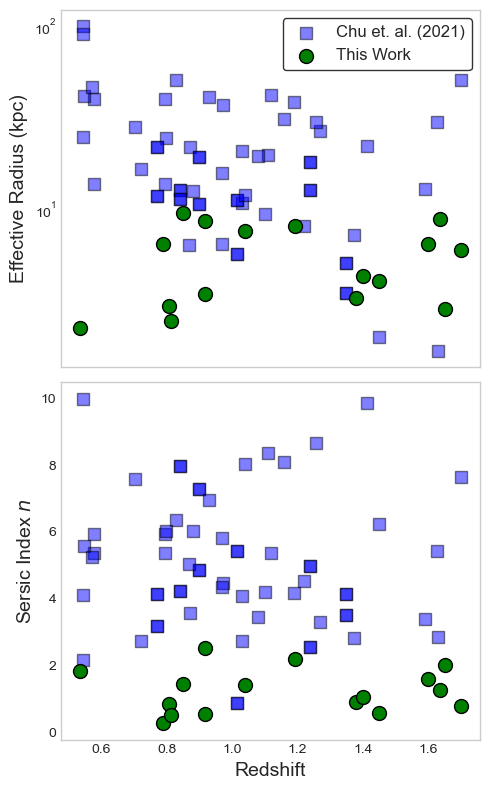

In [281]:
# Create two separate plots sharing the x-axis without using the spec_z mask
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

# Plot for Redshift vs Effective Radius
ax1.scatter(hst_bcgs['z'], hst_bcgs['re'], 
            marker='s', edgecolors='k', s=70, label='Chu et. al. (2021)', alpha=0.5, color='blue')

ax1.scatter(sersic_df['redshift'], sersic_df['sersic_re_kpc'], 
            marker='o', edgecolors='k', s=100, label='This Work', alpha=1, color='green')

ax1.set_ylabel("Effective Radius (kpc)", fontsize=14)
ax1.legend(fontsize=12,frameon=True, edgecolor='k')
ax1.grid(False)
# ax1.set_ylim(0,35)
ax1.set_yscale('log')

# Plot for Redshift vs Sersic Index n
sc2 = ax2.scatter(hst_bcgs['z'], hst_bcgs['n'], 
                  marker='s', edgecolors='k', s=70, alpha=0.5, color='blue', label='HST BCGs')

sc3 = ax2.scatter(sersic_df['redshift'], sersic_df['sersic_n'], 
                  marker='o', edgecolors='k', s=100, alpha=1, color='green', label='Sersic Data BCGs')

ax2.set_xlabel("Redshift", fontsize=14)
ax2.set_ylabel("Sersic Index $n$", fontsize=14)
# ax2.legend(fontsize=12,frameon=True, edgecolor='k')
ax2.grid(False)

# Adjust layout and display
plt.tight_layout()
plt.show()

fig.savefig("plots/re-n-mstar.png", dpi = 300)
